In [1]:
import open3d as o3d
import numpy as np
import copy
import os
import sys

# monkey patches visualization and provides helpers to load geometries
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[download_utils.py] F:\WorkSpace\Project_Remote\open3d_learn\examples\test_data\open3d_downloads\RGBD\normal_map.npy already exists, skipped.
[download_utils.py] F:\WorkSpace\Project_Remote\open3d_learn\examples\test_data\open3d_downloads\RGBD\raycast_vtx_004.npy already exists, skipped.
[download_utils.py] F:\WorkSpace\Project_Remote\open3d_learn\examples\test_data\open3d_downloads\RGBD\vertex_map.npy already exists, skipped.
[download_utils.py] F:\WorkSpace\Project_Remote\open3d_learn\examples\test_data\open3d_downloads\tests\bunnyData.pts already exists, skipped.
[download_utils.py] F:\WorkSpace\Project_Remote\open3d_learn\examples\test_data\open3d_downloads\tests\point_cloud_sample1.pts already exists, skipped.
[download_utils.py] F:\WorkSpace\Project_Remote\open3d_learn\examples\test_data\open3d_downloads\tests\poi

# Mesh
Open3D has a data structure for 3D triangle meshes called `TriangleMesh`.
The code below shows how to read a triangle mesh from a `ply` file and print its vertices and triangles.

In [2]:
print("Testing mesh in Open3D...")
mesh = o3dtut.get_knot_mesh()
print(mesh)
print('Vertices:')
print(np.asarray(mesh.vertices))
print('Triangles:')
print(np.asarray(mesh.triangles))

Testing mesh in Open3D...
TriangleMesh with 1440 points and 2880 triangles.
Vertices:
[[  4.51268387  28.68865967 -76.55680847]
 [  7.63622284  35.52046967 -69.78063965]
 [  6.21986008  44.22465134 -64.82303619]
 ...
 [-22.12651634  31.28466606 -87.37570953]
 [-13.91188431  25.4865818  -86.25827026]
 [ -5.27768707  23.36245346 -81.43279266]]
Triangles:
[[   0   12   13]
 [   0   13    1]
 [   1   13   14]
 ...
 [1438   11 1439]
 [1439   11    0]
 [1439    0 1428]]


The `TriangleMesh` class has a few data fields such as `vertices` and `triangles`. Open3D provides direct memory access to these fields via numpy.

## Visualize a 3D mesh

Try to render a mesh with normals (exist: True) and colors (exist: False)


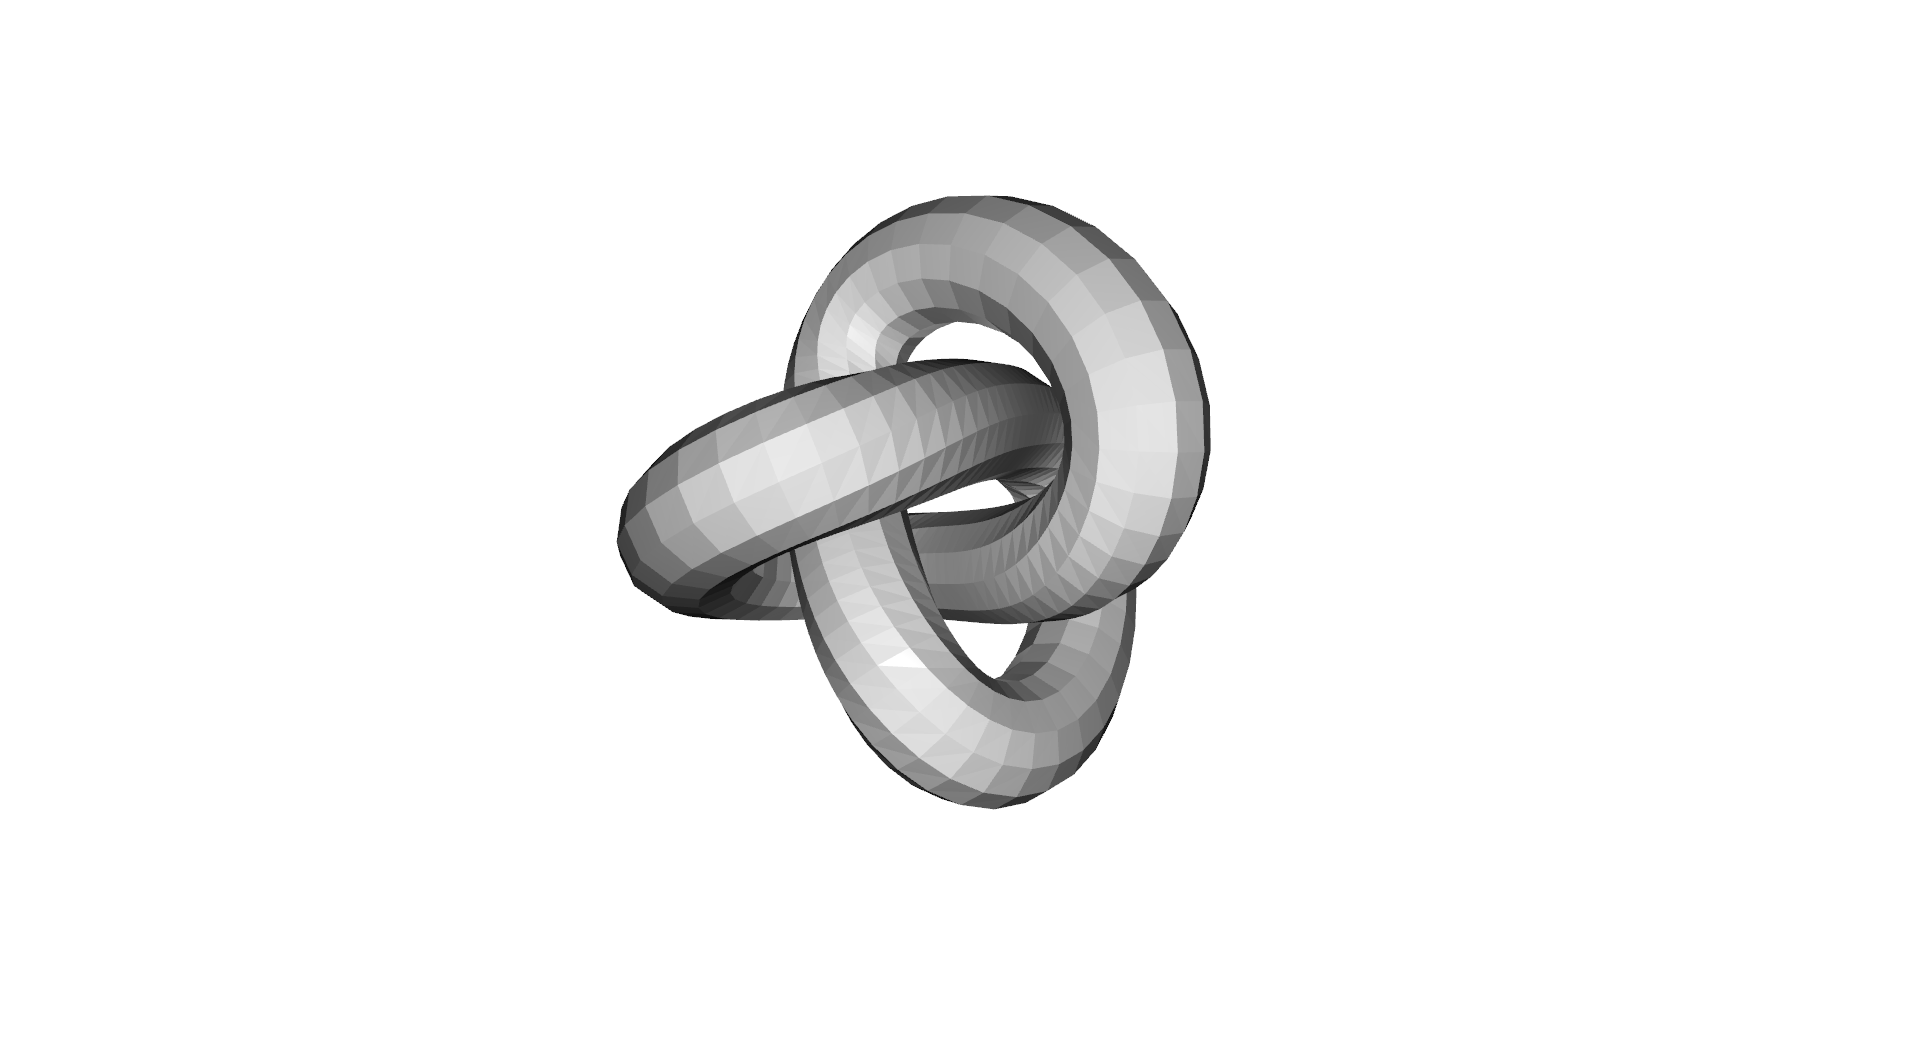

A mesh with no normals and no colors does not look good.


In [3]:
print("Try to render a mesh with normals (exist: " +
      str(mesh.has_vertex_normals()) + ") and colors (exist: " +
      str(mesh.has_vertex_colors()) + ")")
o3d.visualization.draw_geometries([mesh])
print("A mesh with no normals and no colors does not look good.")

You can rotate and move the mesh but it is painted with uniform gray color and does not look `3d`. The reason is that the current mesh does not have normals for vertices or faces. So uniform color shading is used instead of a more sophisticated Phong shading.

## Surface normal estimation
Let’s draw the mesh with surface normals.

Computing normal and rendering it.
[[ 0.79164373 -0.53951444  0.28674793]
 [ 0.8319824  -0.53303008  0.15389681]
 [ 0.83488162 -0.09250101  0.54260136]
 ...
 [ 0.16269924 -0.76215917 -0.6266118 ]
 [ 0.52755226 -0.83707495 -0.14489352]
 [ 0.56778973 -0.76467734 -0.30476777]]


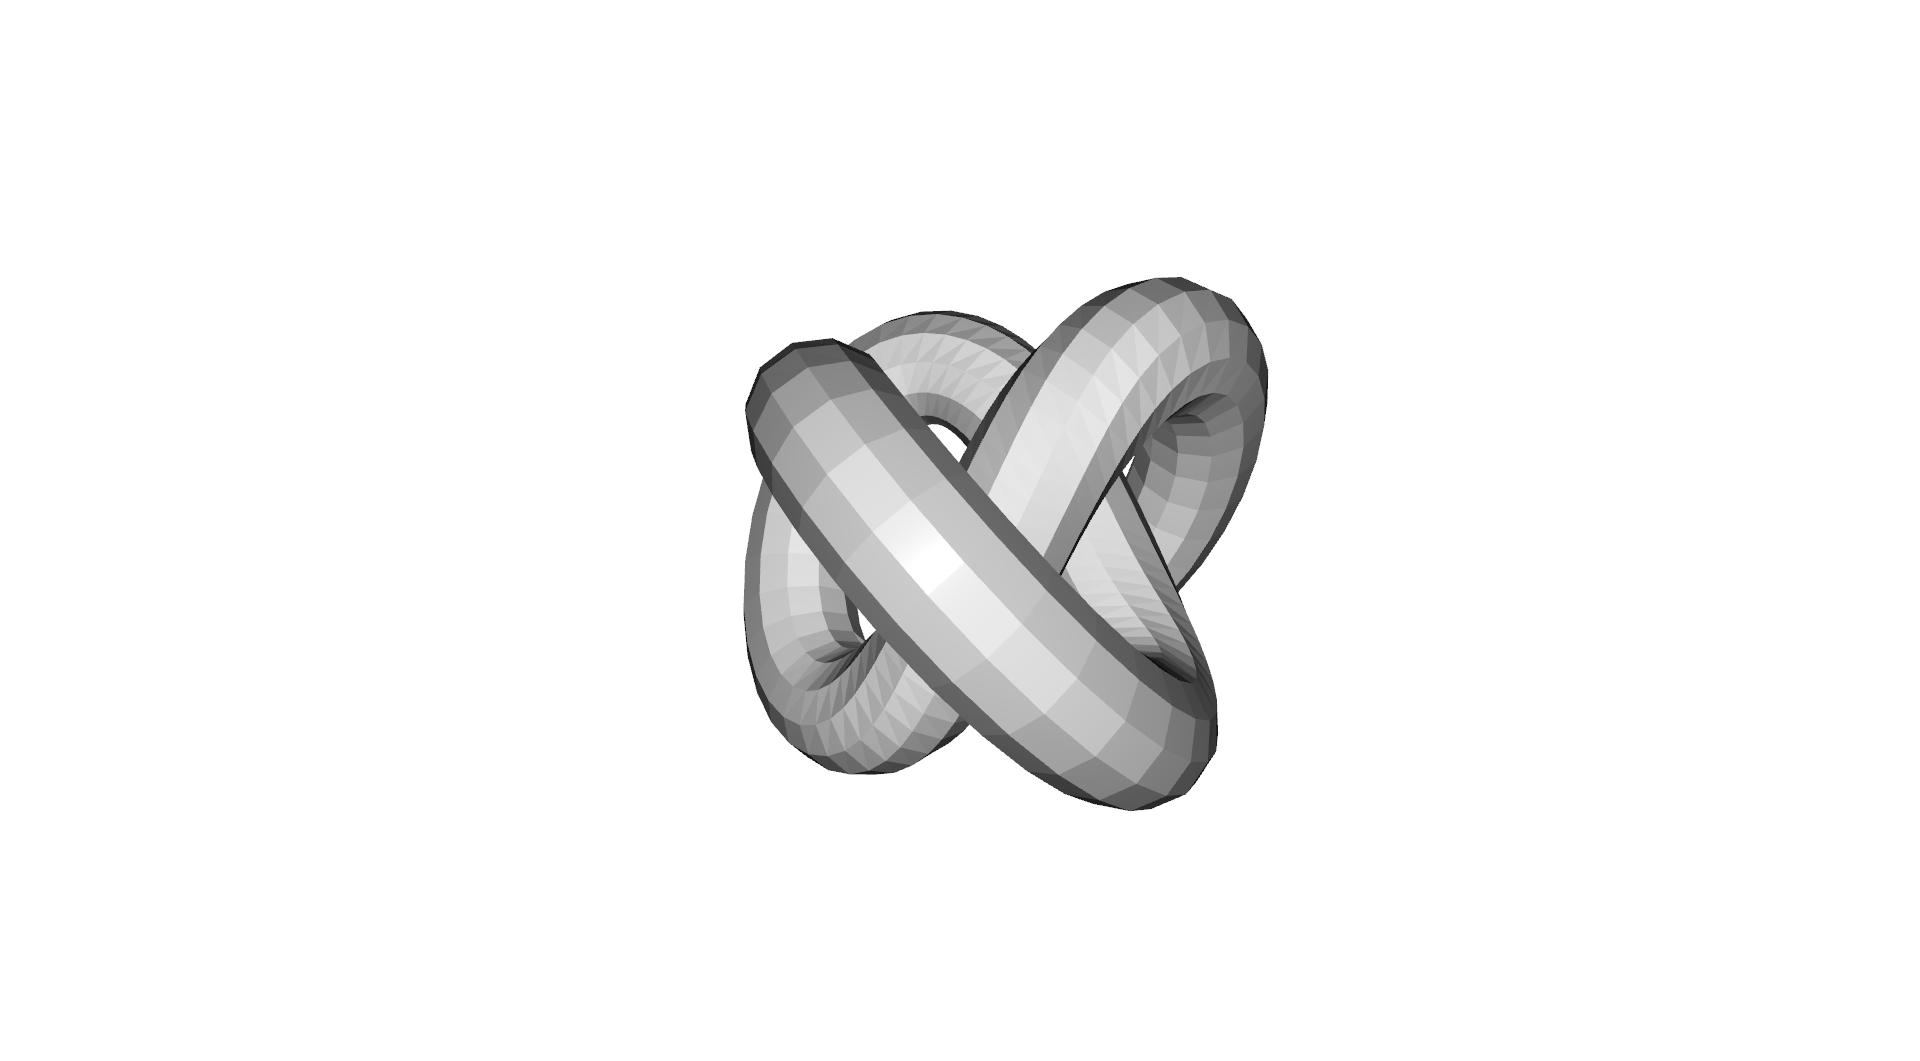

In [4]:
print("Computing normal and rendering it.")
mesh.compute_vertex_normals()
print(np.asarray(mesh.triangle_normals))
o3d.visualization.draw_geometries([mesh])

It uses `compute_vertex_normals` and `paint_uniform_color` which are member functions of `mesh`.

## Crop mesh
We remove half of the surface by directly operating on the `triangle` and `triangle_normals` data fields of the mesh. This is done via numpy.

We make a partial mesh of only the first half triangles.
std::vector<Eigen::Vector3i> with 1440 elements.
Use numpy.asarray() to access data.


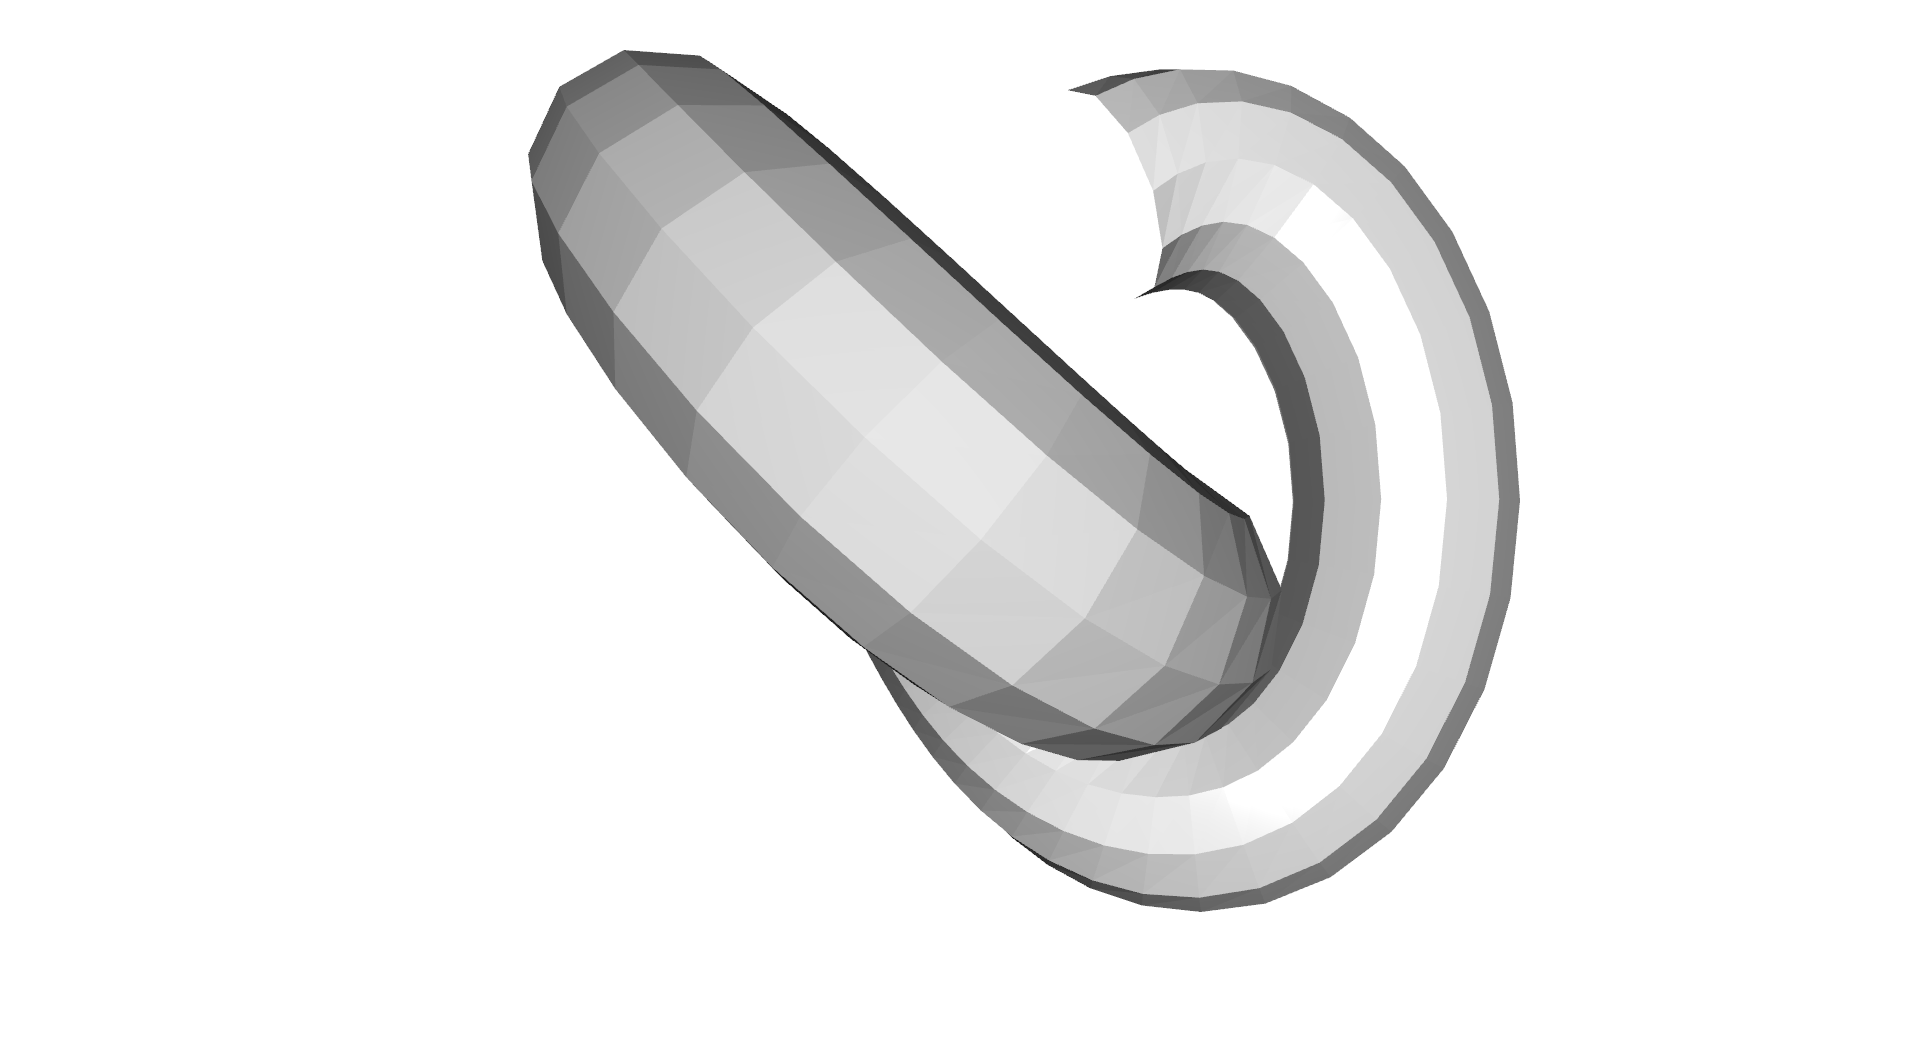

In [6]:
print("We make a partial mesh of only the first half triangles.")
mesh1 = copy.deepcopy(mesh)
mesh1.triangles = o3d.utility.Vector3iVector(
    np.asarray(mesh1.triangles)[:len(mesh1.triangles) // 2, :])
mesh1.triangle_normals = o3d.utility.Vector3dVector(
    np.asarray(mesh1.triangle_normals)[:len(mesh1.triangle_normals) // 2, :])
print(mesh1.triangles)
o3d.visualization.draw_geometries([mesh1])

## Paint mesh
`paint_uniform_color` paints the mesh with a uniform color. The color is in RGB space, [0, 1] range.

Painting the mesh


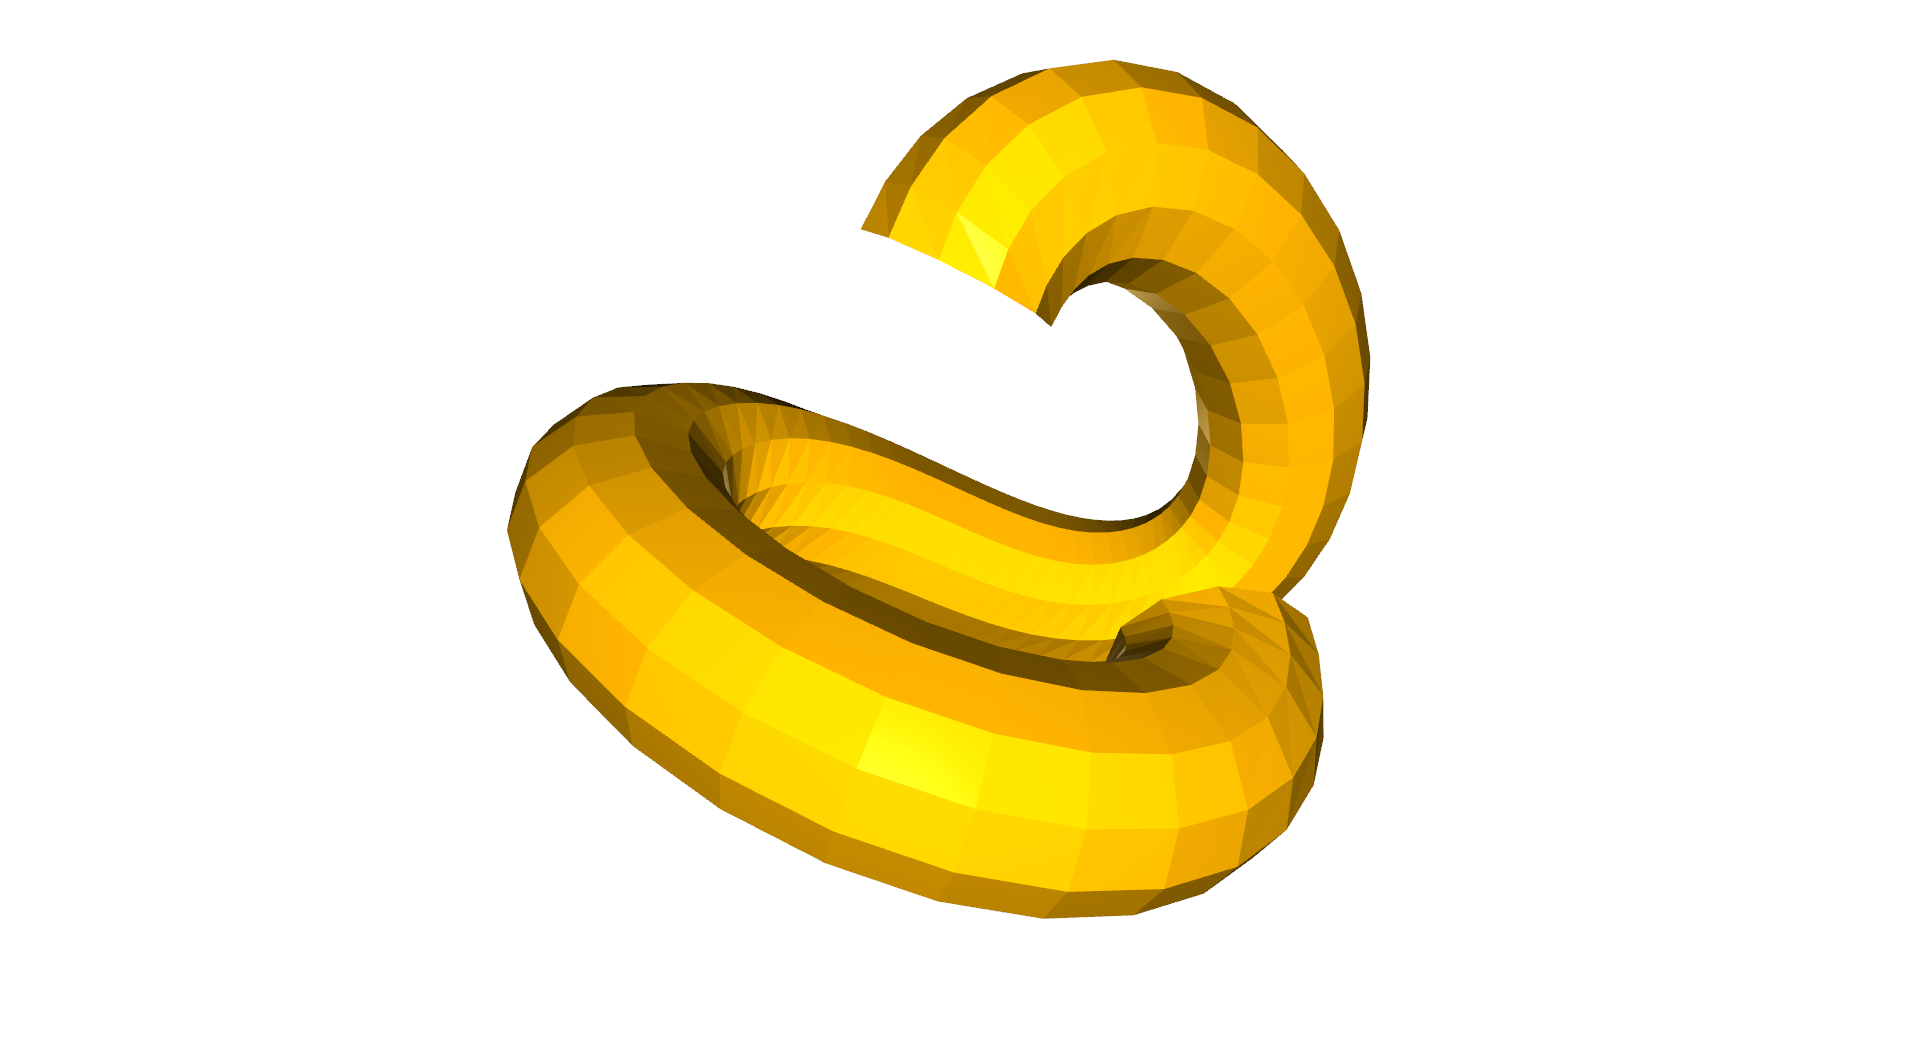

In [7]:
print("Painting the mesh")
mesh1.paint_uniform_color([1, 0.706, 0])
o3d.visualization.draw_geometries([mesh1])

## Mesh properties
A triangle mesh has several properties that can be tested with Open3D. One important property is the manifold property, where we can test the triangle mesh if it is edge manifold `is_edge_manifold` and if it is `is_vertex_manifold`. A triangle mesh is edge manifold, if each edge is bounding either one or two triangles. The function `is_edge_manifold` has the `bool` parameter `allow_boundary_edges` that defines if boundary edges should be allowed. Further, a triangle mesh is vertex manifold if the star of the vertex is edge-manifold and edge-connected, e.g., two or more faces connected only by a vertex and not by an edge.

Another property is the test of self-intersection. The function `is_self_intersecting` returns `True` if there exists a triangle in the mesh that is intersecting another mesh. A watertight mesh can be defined as a mesh that is edge manifold, vertex manifold and not self intersecting. The function `is_watertight` implements this check in Open3D.

We also can test the triangle mesh, if it is orientable, i.e. the triangles can be oriented in such a way that all normals point towards the outside. The corresponding function in Open3D is called `is_orientable`.

The code below tests a number of triangle meshes against those properties and visualizes the results. Non-manifold edges are shown in red, boundary edges in green, non-manifold vertices are visualized as green points, and self-intersecting triangles are shown in pink. 

In [9]:
def check_properties(name, mesh):
    mesh.compute_vertex_normals()

    edge_manifold = mesh.is_edge_manifold(allow_boundary_edges=True)
    edge_manifold_boundary = mesh.is_edge_manifold(allow_boundary_edges=False)
    vertex_manifold = mesh.is_vertex_manifold()
    self_intersecting = mesh.is_self_intersecting()
    watertight = mesh.is_watertight()
    orientable = mesh.is_orientable()

    print(name)
    print(f"  edge_manifold:          {edge_manifold}")
    print(f"  edge_manifold_boundary: {edge_manifold_boundary}")
    print(f"  vertex_manifold:        {vertex_manifold}")
    print(f"  self_intersecting:      {self_intersecting}")
    print(f"  watertight:             {watertight}")
    print(f"  orientable:             {orientable}")

    geoms = [mesh]
    if not edge_manifold:
        edges = mesh.get_non_manifold_edges(allow_boundary_edges=True)
        geoms.append(o3dtut.edges_to_lineset(mesh, edges, (1, 0, 0)))
    if not edge_manifold_boundary:
        edges = mesh.get_non_manifold_edges(allow_boundary_edges=False)
        geoms.append(o3dtut.edges_to_lineset(mesh, edges, (0, 1, 0)))
    if not vertex_manifold:
        verts = np.asarray(mesh.get_non_manifold_vertices())
        pcl = o3d.geometry.PointCloud(
            points=o3d.utility.Vector3dVector(np.asarray(mesh.vertices)[verts]))
        pcl.paint_uniform_color((0, 0, 1))
        geoms.append(pcl)
    if self_intersecting:
        intersecting_triangles = np.asarray(
            mesh.get_self_intersecting_triangles())
        intersecting_triangles = intersecting_triangles[0:1]
        intersecting_triangles = np.unique(intersecting_triangles)
        print("  # visualize self-intersecting triangles")
        triangles = np.asarray(mesh.triangles)[intersecting_triangles]
        edges = [
            np.vstack((triangles[:, i], triangles[:, j]))
            for i, j in [(0, 1), (1, 2), (2, 0)]
        ]
        edges = np.hstack(edges).T
        edges = o3d.utility.Vector2iVector(edges)
        geoms.append(o3dtut.edges_to_lineset(mesh, edges, (1, 0, 1)))
    o3d.visualization.draw_geometries(geoms, mesh_show_back_face=True)

Knot
  edge_manifold:          True
  edge_manifold_boundary: True
  vertex_manifold:        True
  self_intersecting:      False
  watertight:             True
  orientable:             True


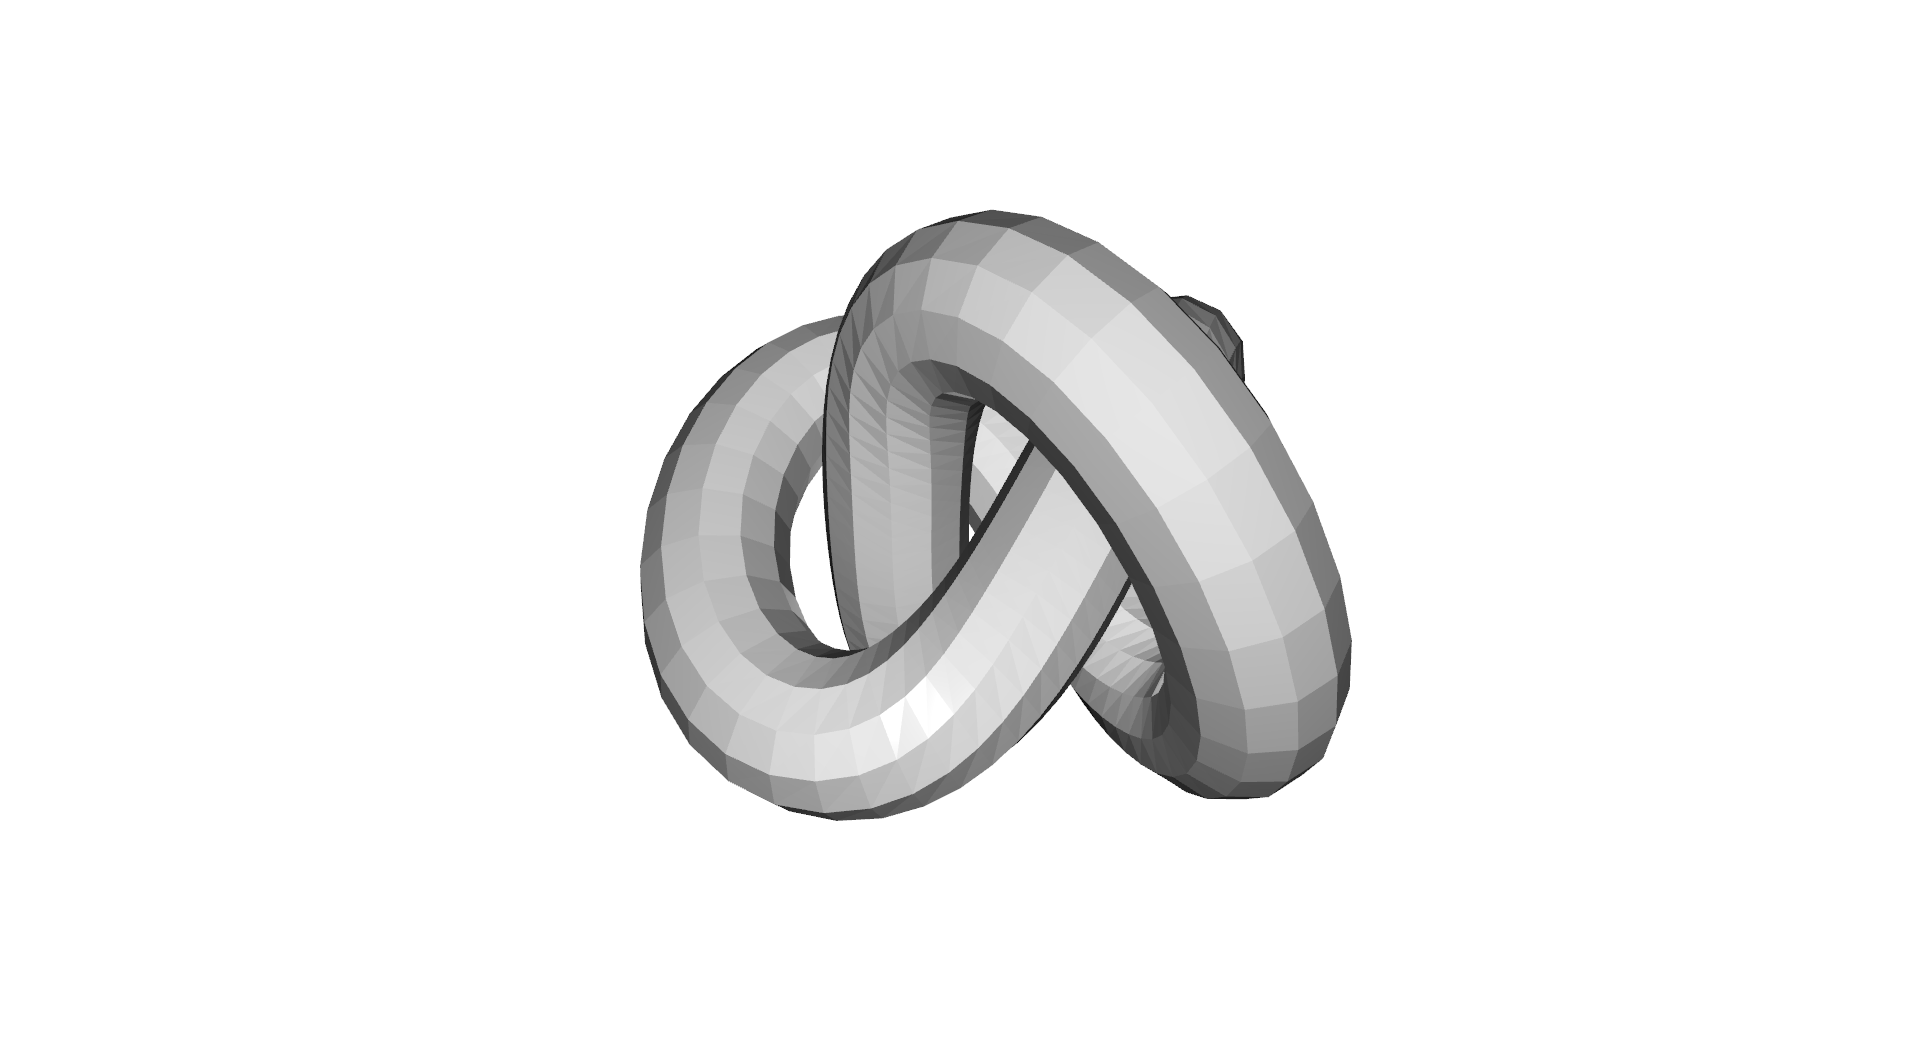

Moebius
  edge_manifold:          True
  edge_manifold_boundary: False
  vertex_manifold:        True
  self_intersecting:      False
  watertight:             False
  orientable:             False


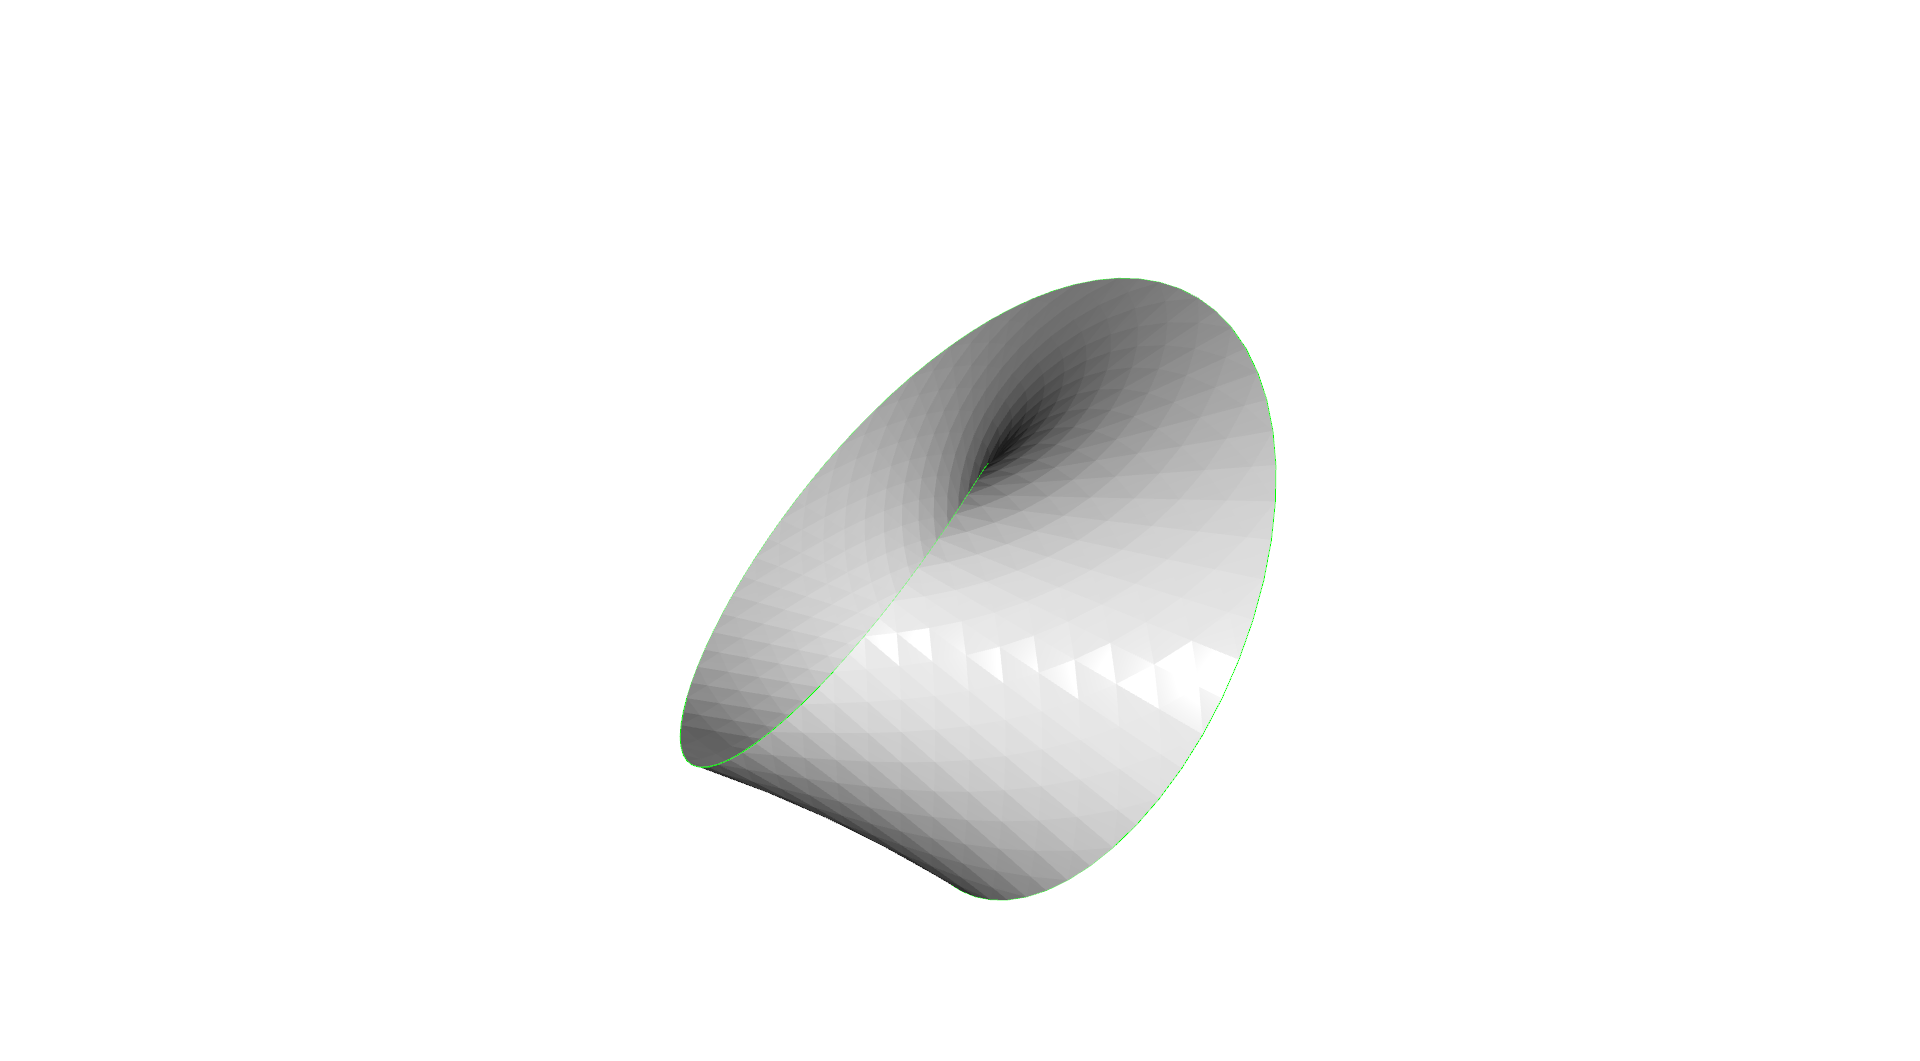

non-manifold edge
  edge_manifold:          False
  edge_manifold_boundary: False
  vertex_manifold:        True
  self_intersecting:      False
  watertight:             False
  orientable:             True


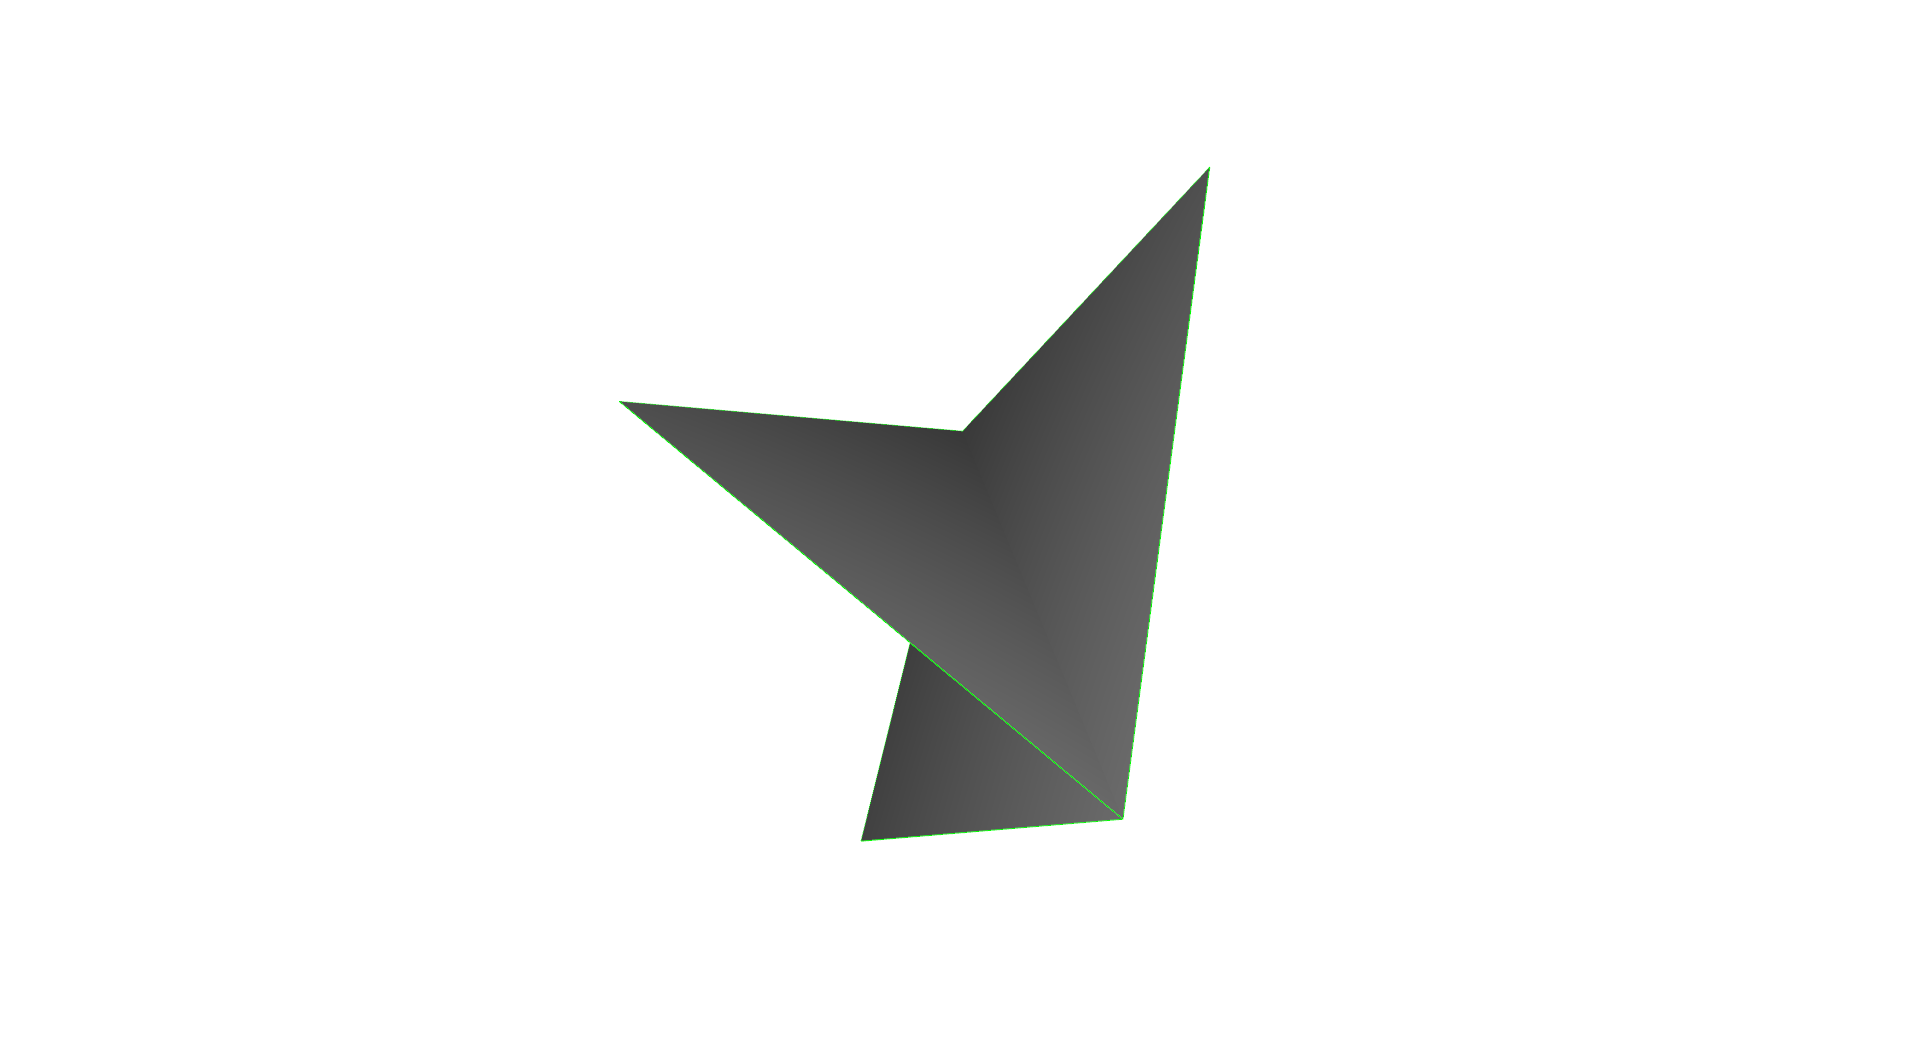

non-manifold vertex
  edge_manifold:          True
  edge_manifold_boundary: True
  vertex_manifold:        False
  self_intersecting:      False
  watertight:             False
  orientable:             True


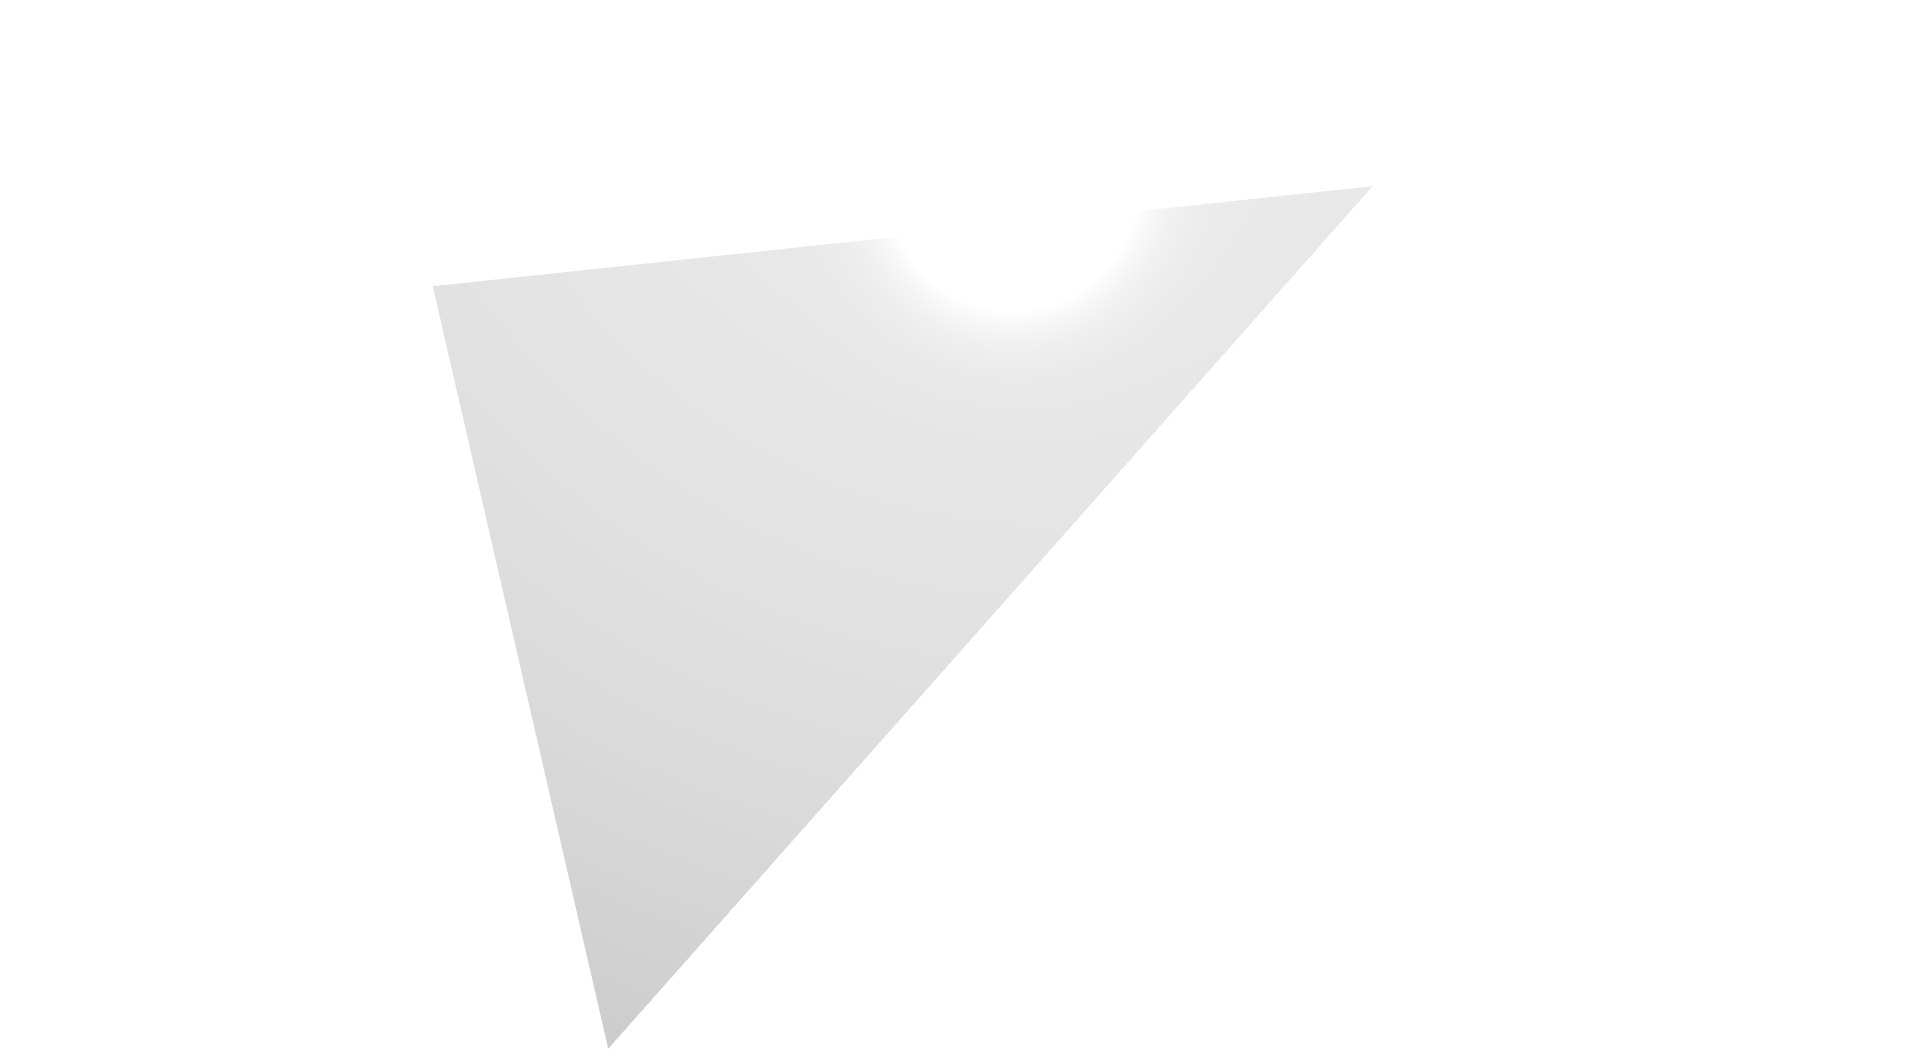

open box
  edge_manifold:          True
  edge_manifold_boundary: False
  vertex_manifold:        True
  self_intersecting:      False
  watertight:             False
  orientable:             True


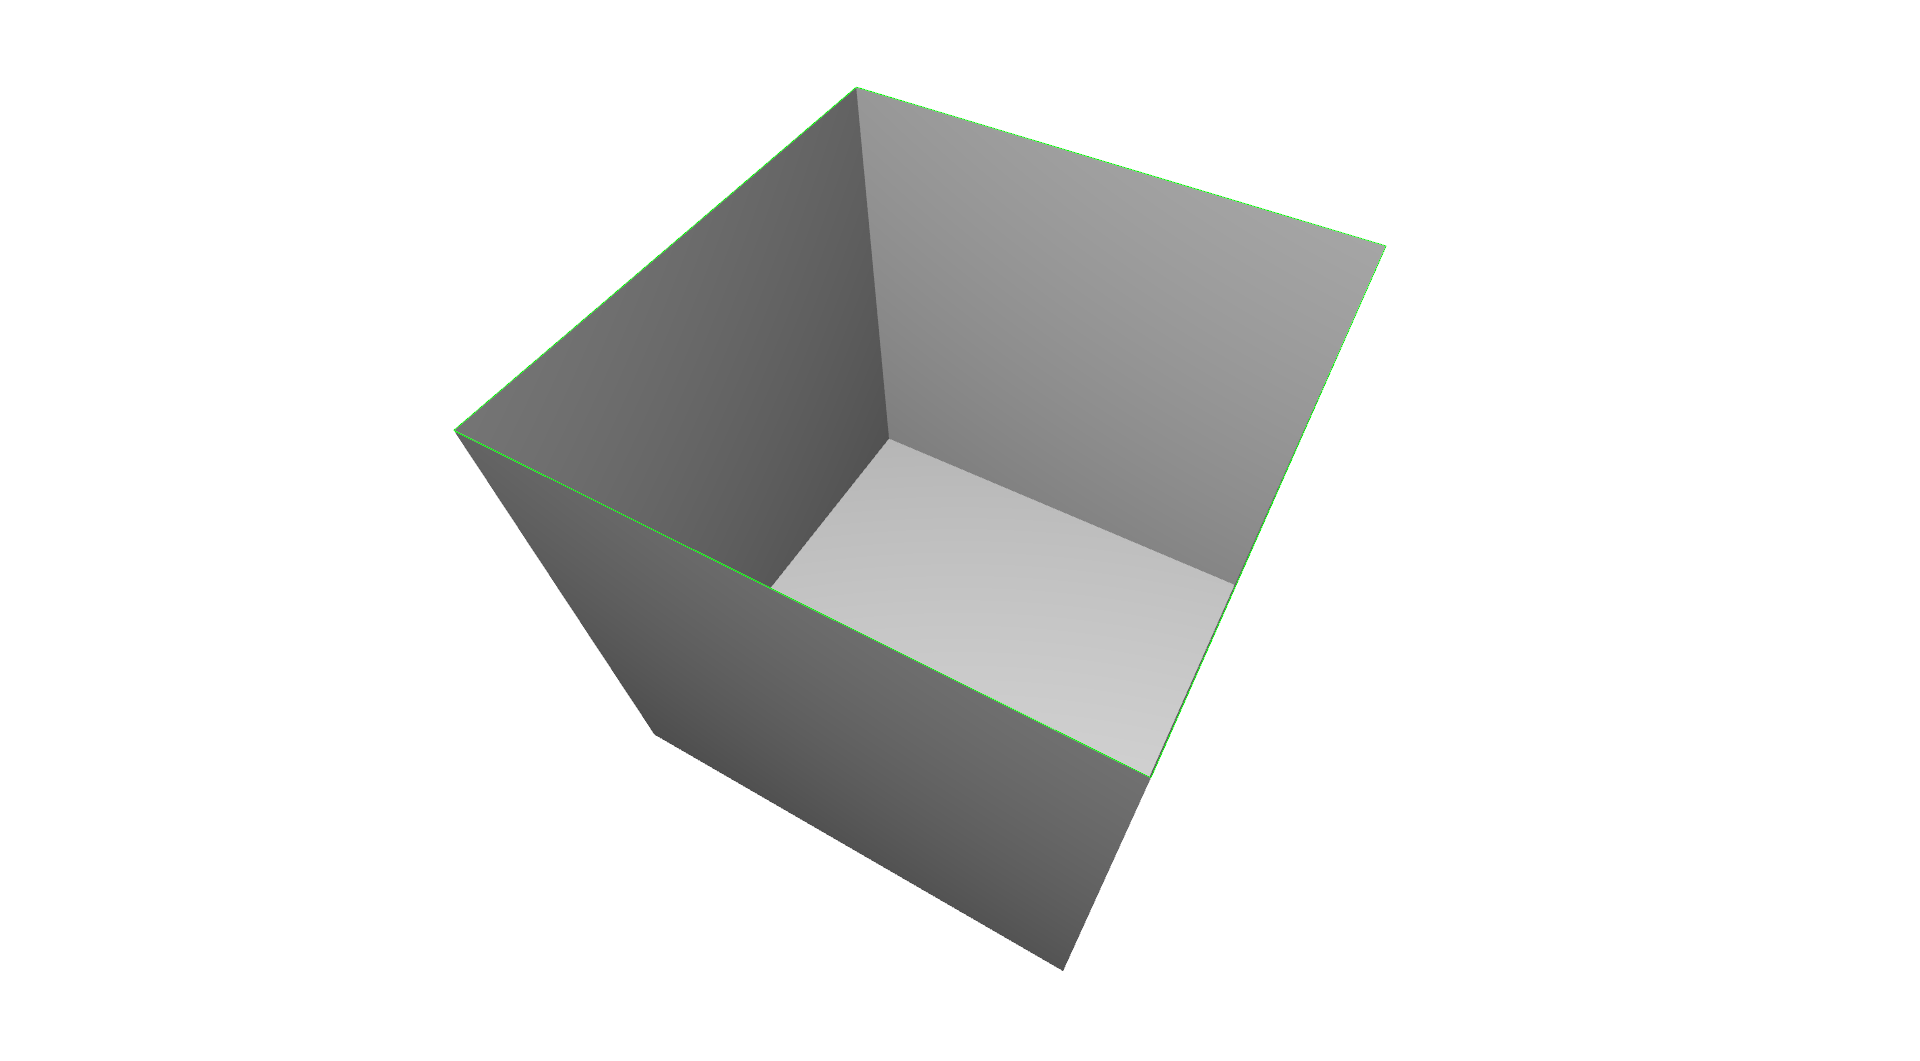

intersecting_boxes
  edge_manifold:          True
  edge_manifold_boundary: True
  vertex_manifold:        True
  self_intersecting:      True
  watertight:             False
  orientable:             True
  # visualize self-intersecting triangles


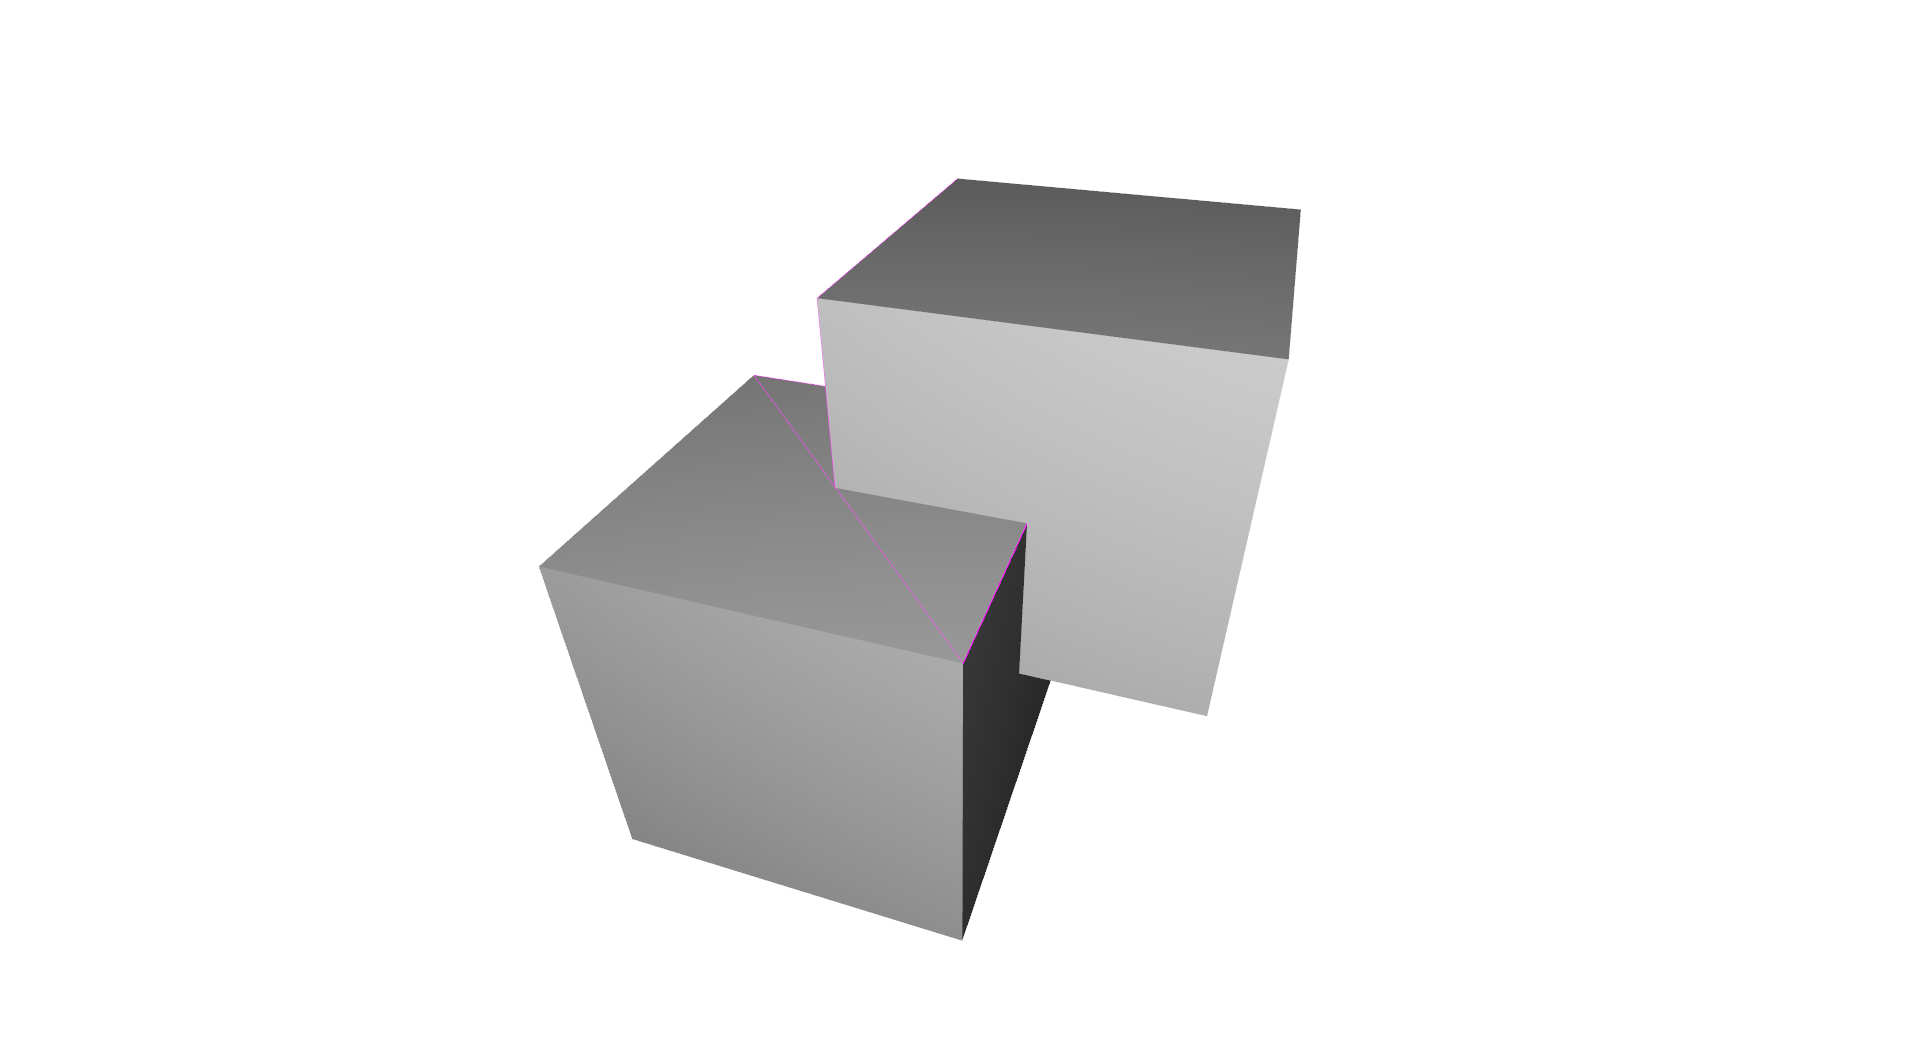

In [10]:
check_properties('Knot', o3dtut.get_knot_mesh())
check_properties('Moebius', o3d.geometry.TriangleMesh.create_moebius(twists=1))
check_properties("non-manifold edge", o3dtut.get_non_manifold_edge_mesh())
check_properties("non-manifold vertex", o3dtut.get_non_manifold_vertex_mesh())
check_properties("open box", o3dtut.get_open_box_mesh())
check_properties("intersecting_boxes", o3dtut.get_intersecting_boxes_mesh())

## Mesh filtering
Open3D contains a number of methods to filter meshes. In the following we show the implemented filters to smooth noisy triangle meshes.

### Average filter
The simplest filter is the average filter. A given vertex $v_i$ is given by the average of the adjacent vertices $\mathcal{N}$

\begin{equation}
v_i = \frac{v_i + \sum_{n \in \mathcal{N}} v_n}{|N| + 1} \,.
\end{equation}

This filter can be used to denoise meshes as demonstrated in the code below. The parameter `number_of_iterations` in the function `filter_smooth_simple` defines the how often the filter is applied to the mesh.

create noisy mesh


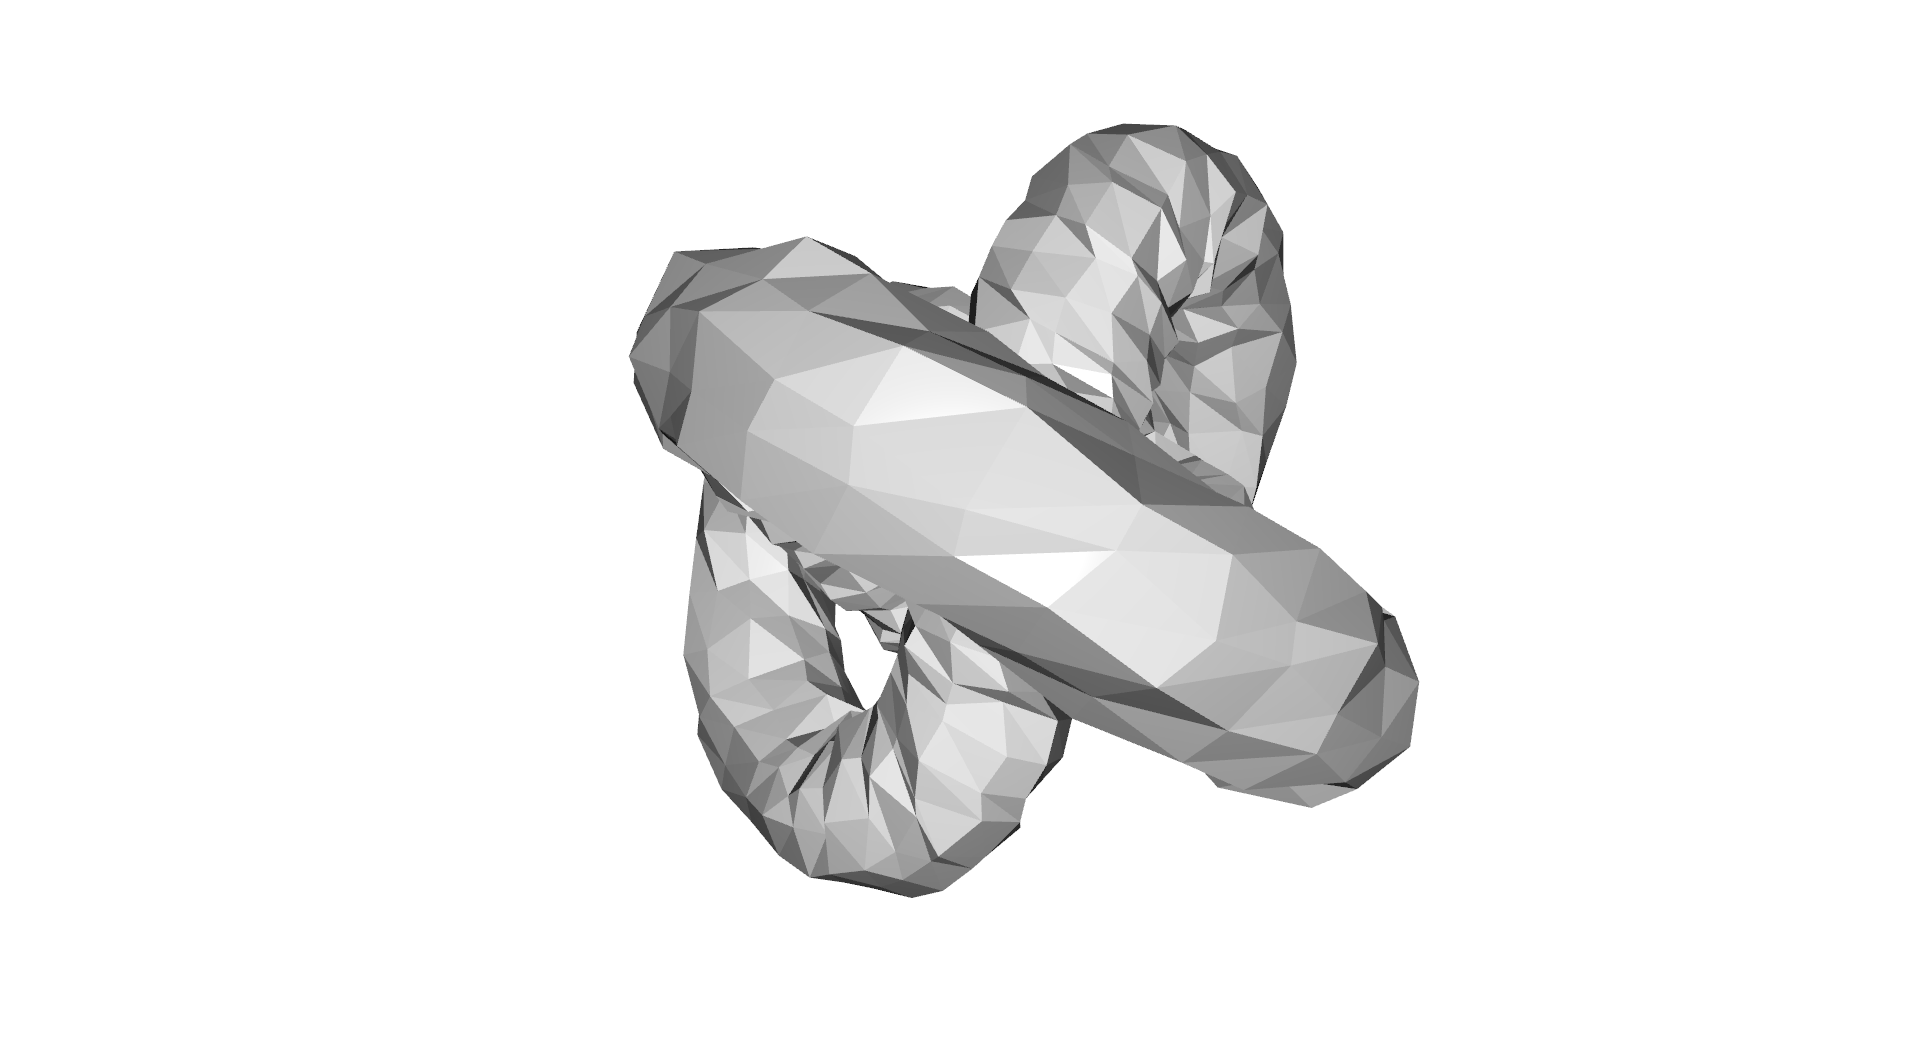

filter with average with 1 iteration


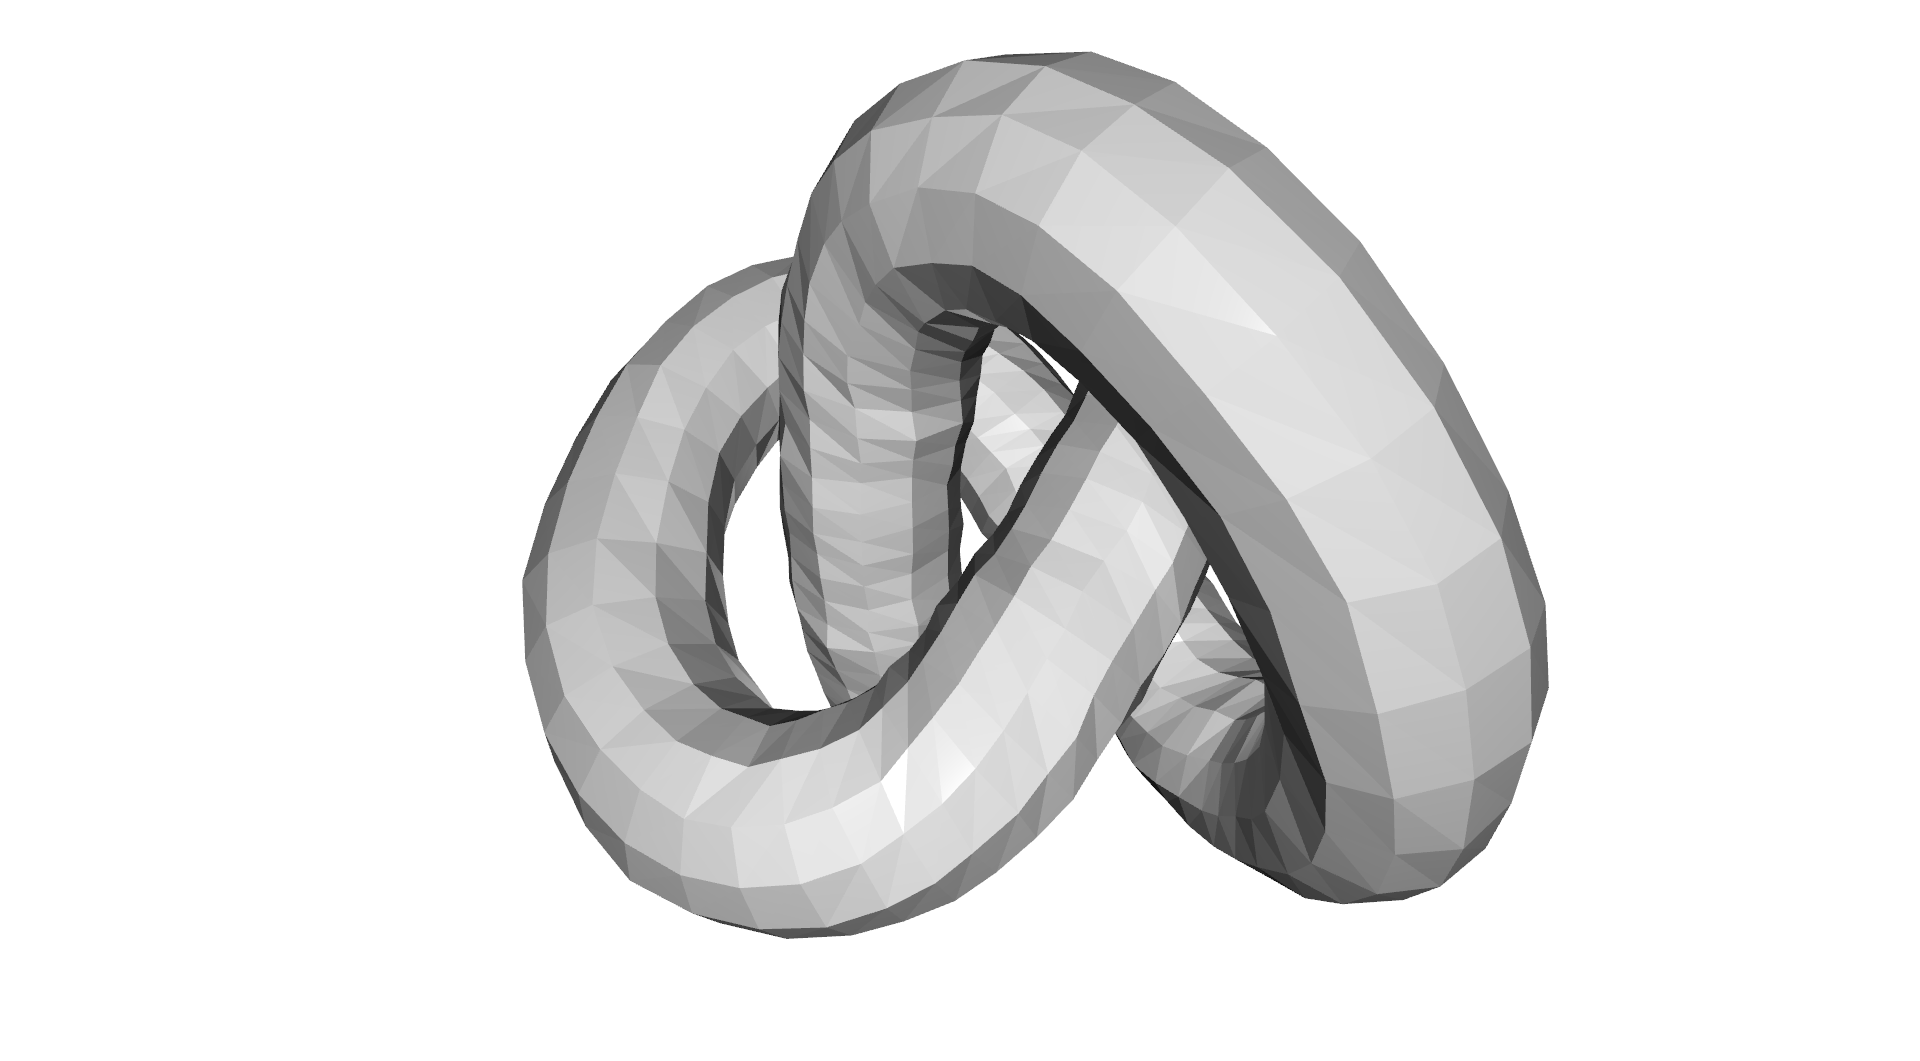

filter with average with 5 iterations


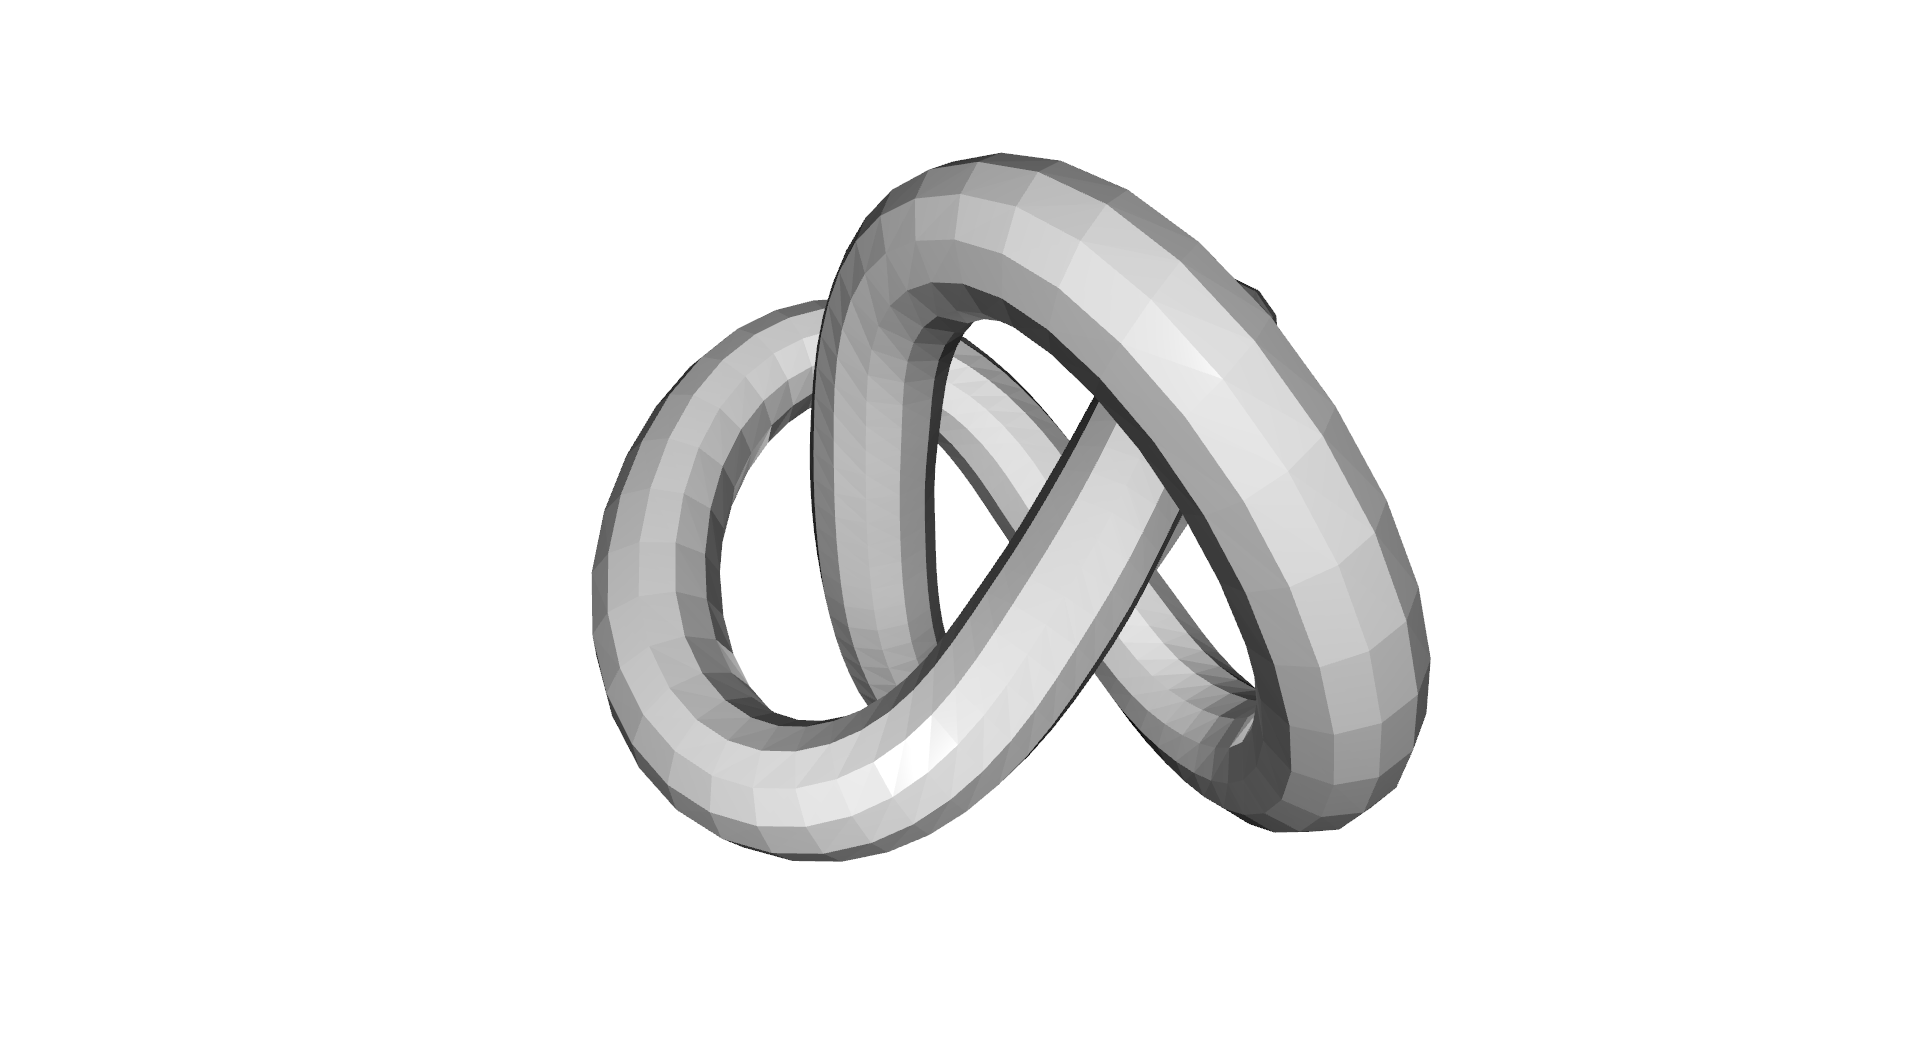

In [11]:
print('create noisy mesh')
mesh_in = o3dtut.get_knot_mesh()
vertices = np.asarray(mesh_in.vertices)
noise = 5
vertices += np.random.uniform(0, noise, size=vertices.shape)
mesh_in.vertices = o3d.utility.Vector3dVector(vertices)
mesh_in.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_in])

print('filter with average with 1 iteration')
mesh_out = mesh_in.filter_smooth_simple(number_of_iterations=1)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])

print('filter with average with 5 iterations')
mesh_out = mesh_in.filter_smooth_simple(number_of_iterations=5)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])

### Laplacian
Another important mesh filter is the Laplacian defined as 

\begin{equation}
v_i = v_i \cdot \lambda \sum_{n \in N} w_n v_n - v_i \,,
\end{equation}

where $\lambda$ is the strength of the filter and $w_n$ are normalized weights that relate to the distance of the neighboring vertices. The filter is implemented in `filter_smooth_laplacian` and has the parameters `number_of_iterations` and `lambda`.

filter with Laplacian with 10 iterations


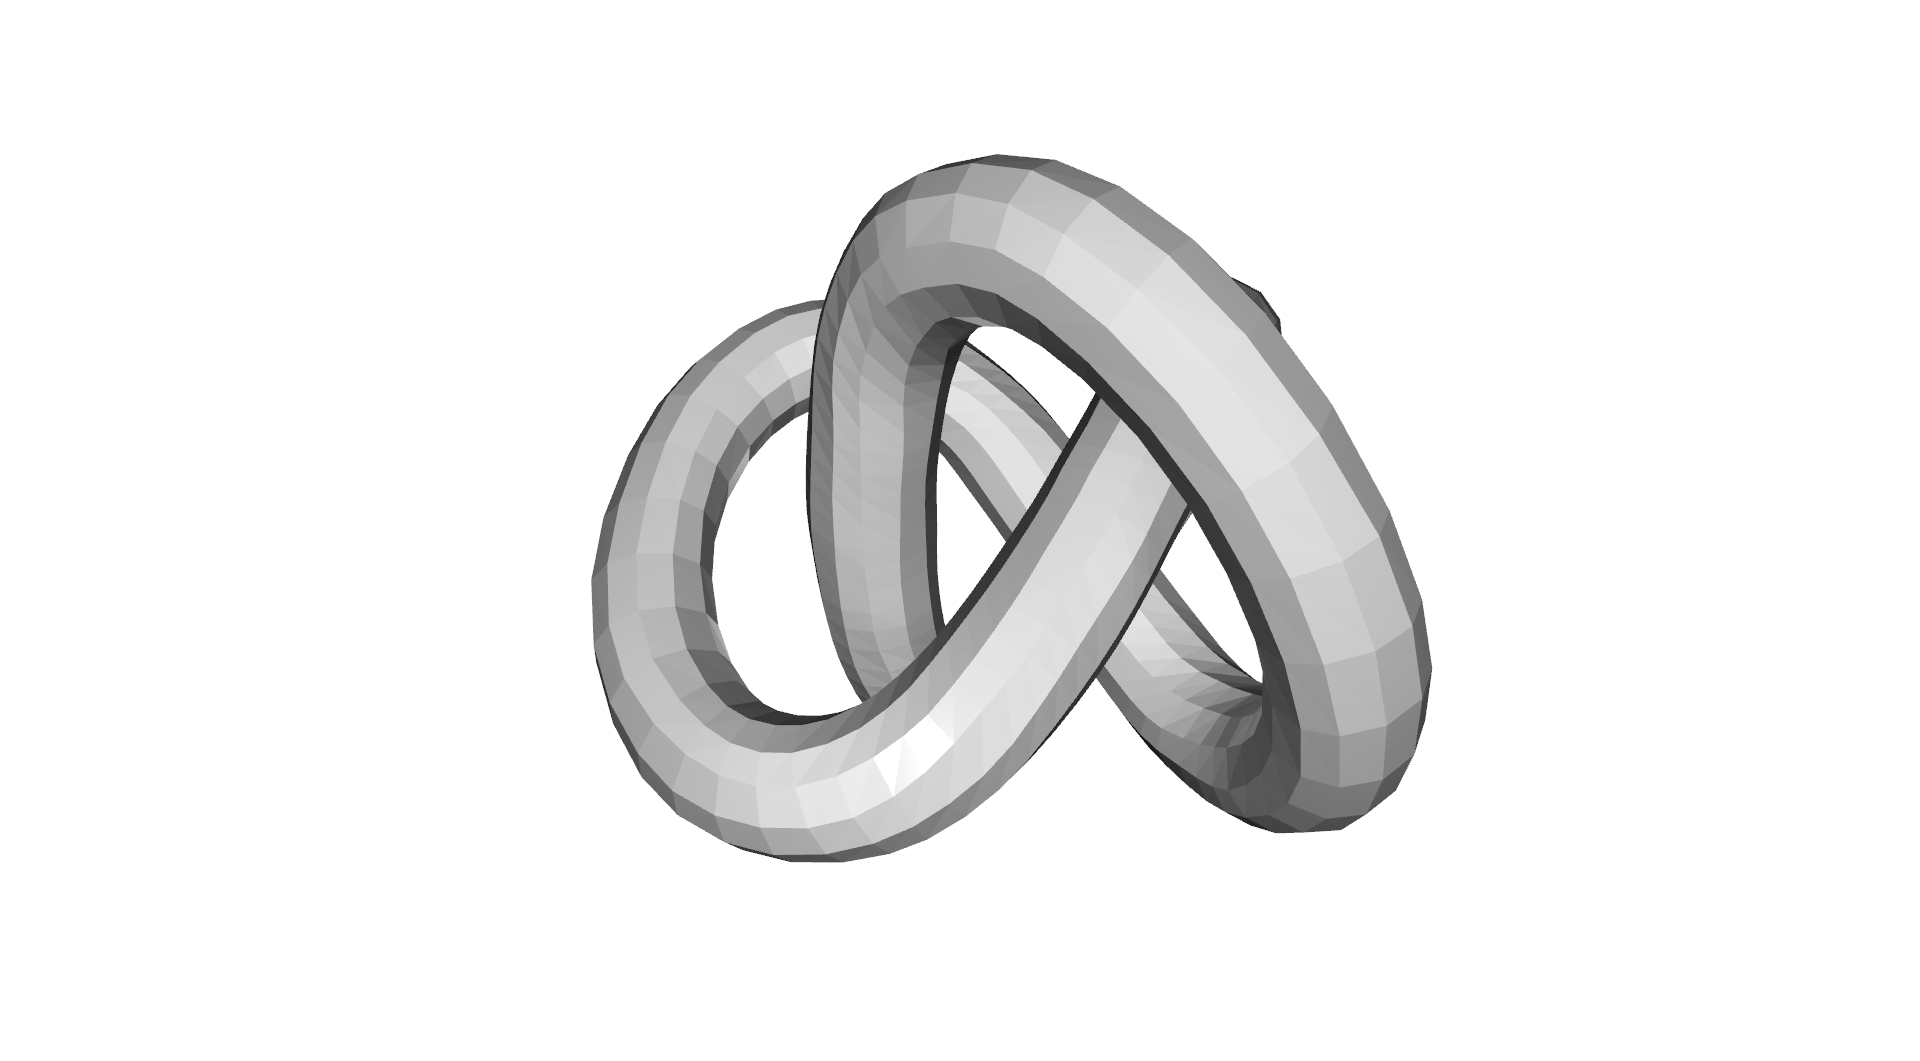

filter with Laplacian with 50 iterations


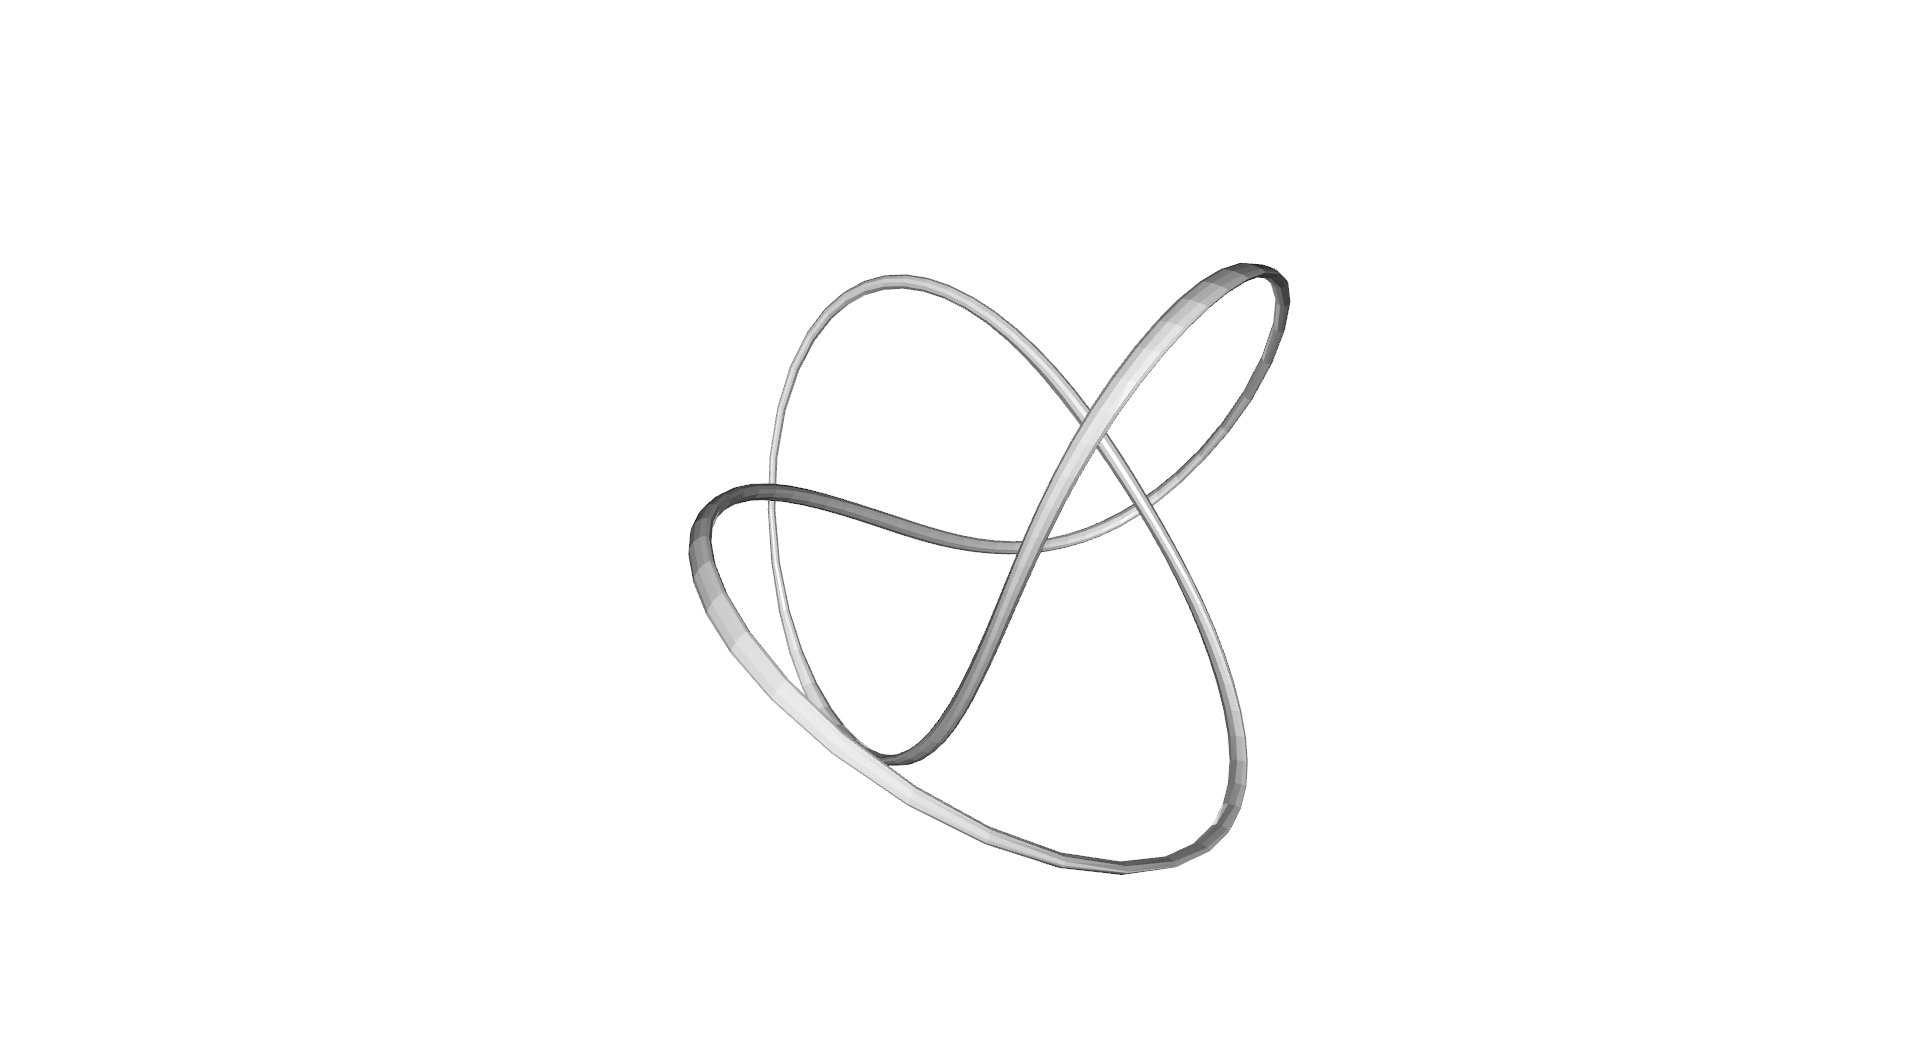

In [12]:
print('filter with Laplacian with 10 iterations')
mesh_out = mesh_in.filter_smooth_laplacian(number_of_iterations=10)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])

print('filter with Laplacian with 50 iterations')
mesh_out = mesh_in.filter_smooth_laplacian(number_of_iterations=50)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])

### Taubin filter
The problem with the average and Laplacian filter is that they lead to a shrinkage of the triangle mesh. [\[Taubin1995\]](../reference.html#Taubin1995) showed that the application of two Laplacian filters with different $\lambda$ parameters can prevent the mesh shrinkage. The filter is implemented in `filter_smooth_taubin`.

filter with Taubin with 10 iterations


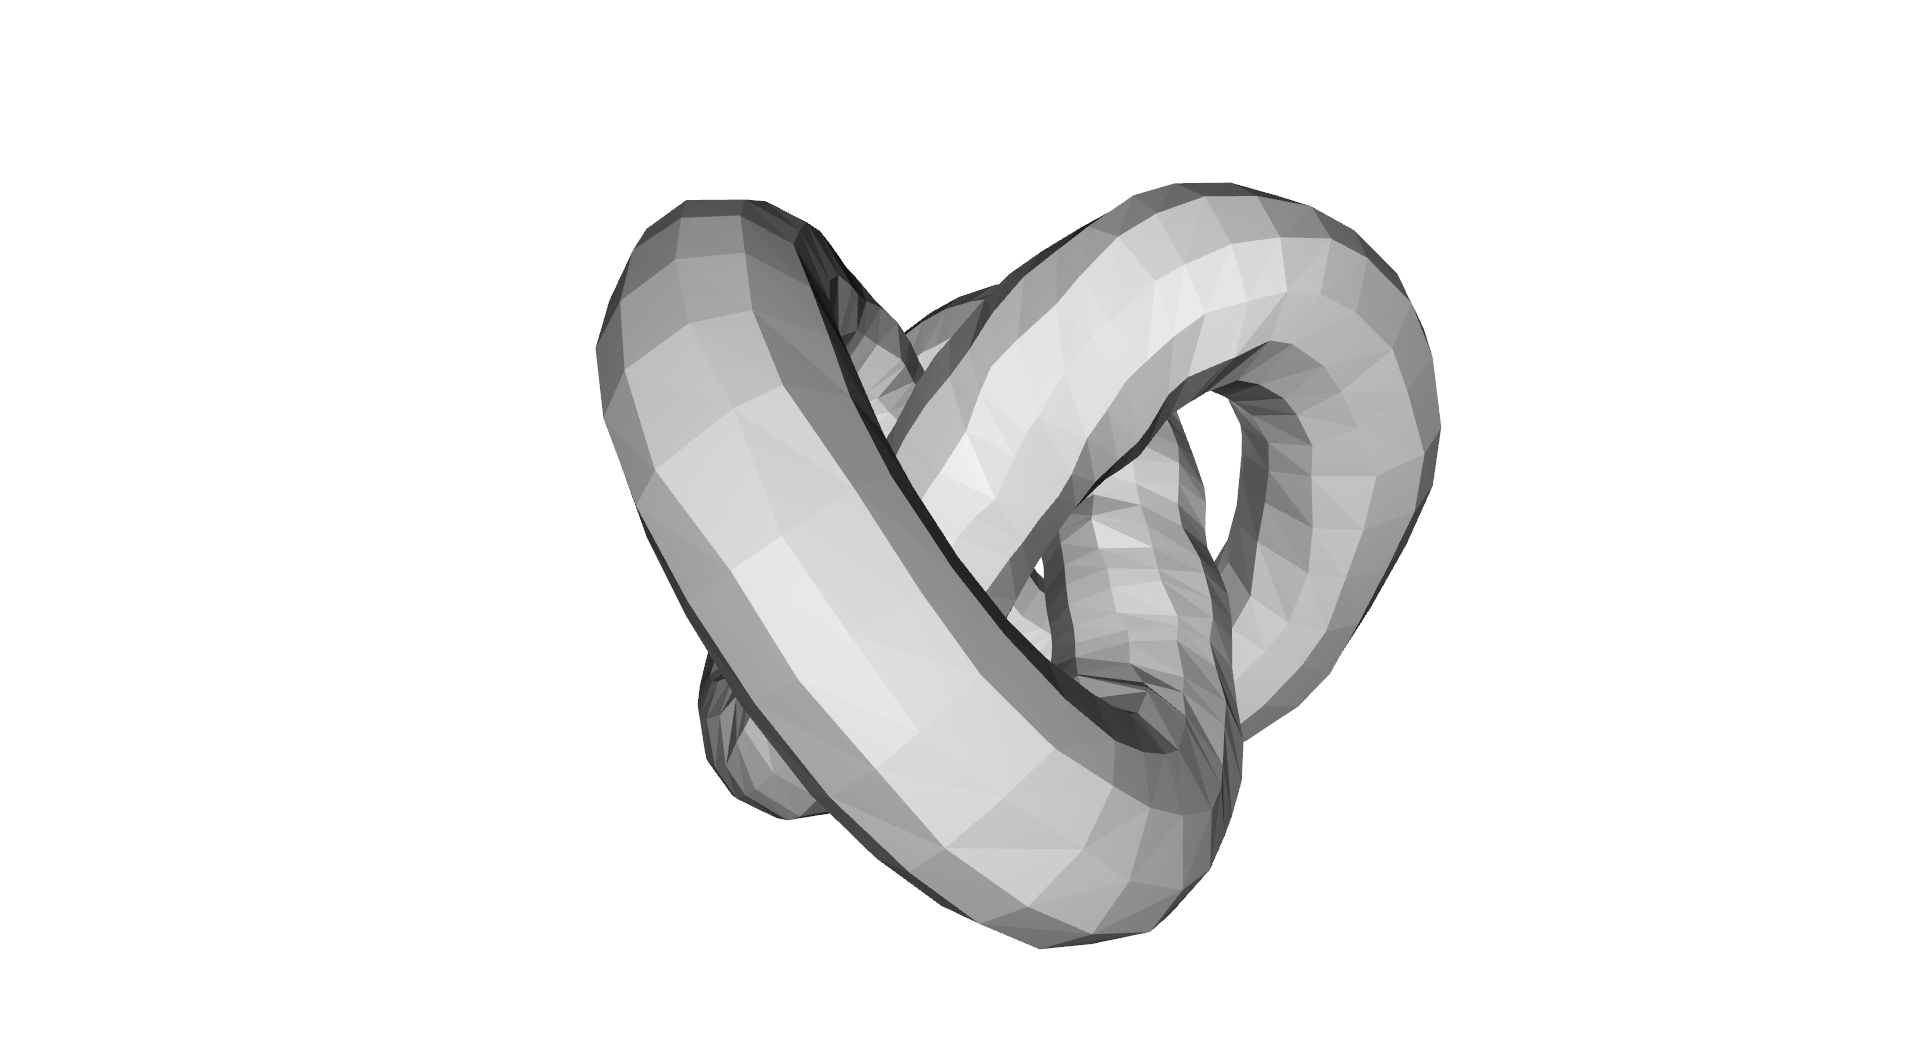

filter with Taubin with 100 iterations


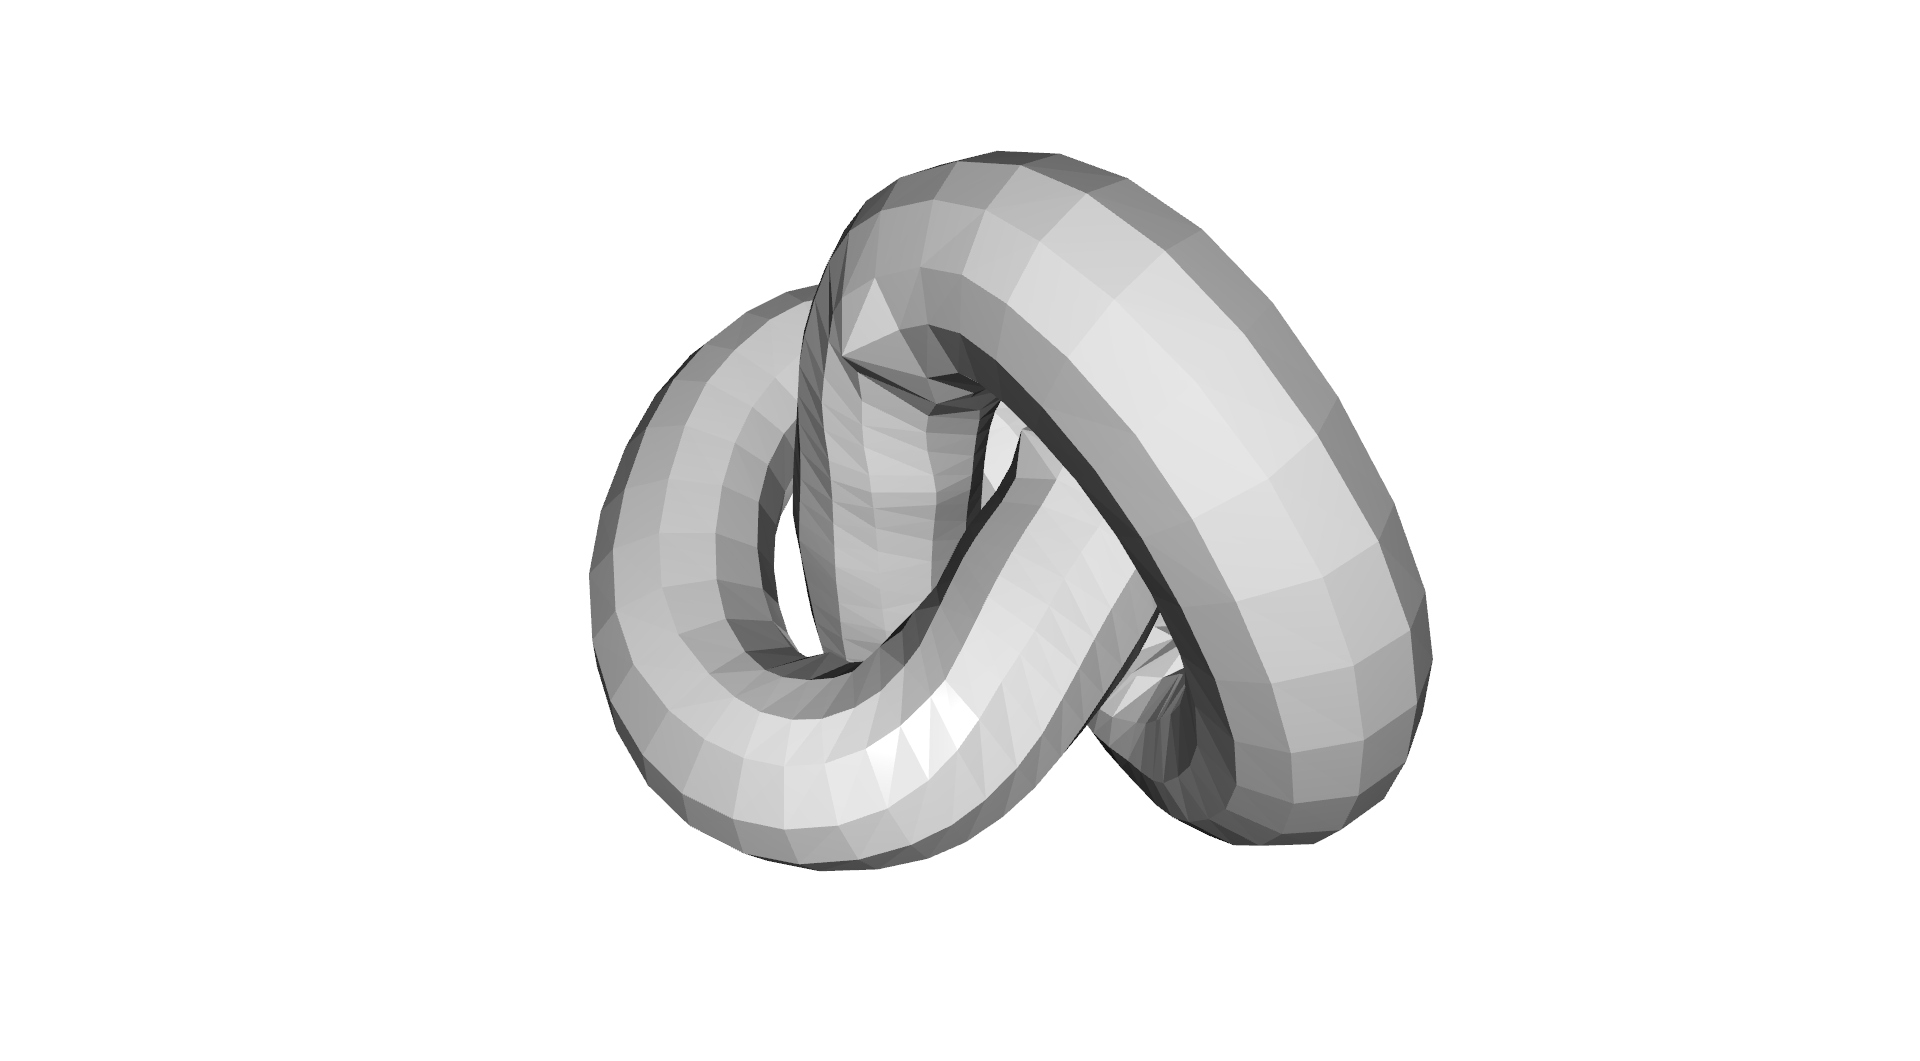

In [13]:
print('filter with Taubin with 10 iterations')
mesh_out = mesh_in.filter_smooth_taubin(number_of_iterations=10)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])

print('filter with Taubin with 100 iterations')
mesh_out = mesh_in.filter_smooth_taubin(number_of_iterations=100)
mesh_out.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_out])

## Sampling
Open3D includes functions to sample point clouds from a triangle mesh. The simplest method is `sample_points_uniformly` that uniformly samples points from the 3D surface based on the triangle area. The parameter `number_of_points` defines how many points are sampled from the triangle surface.

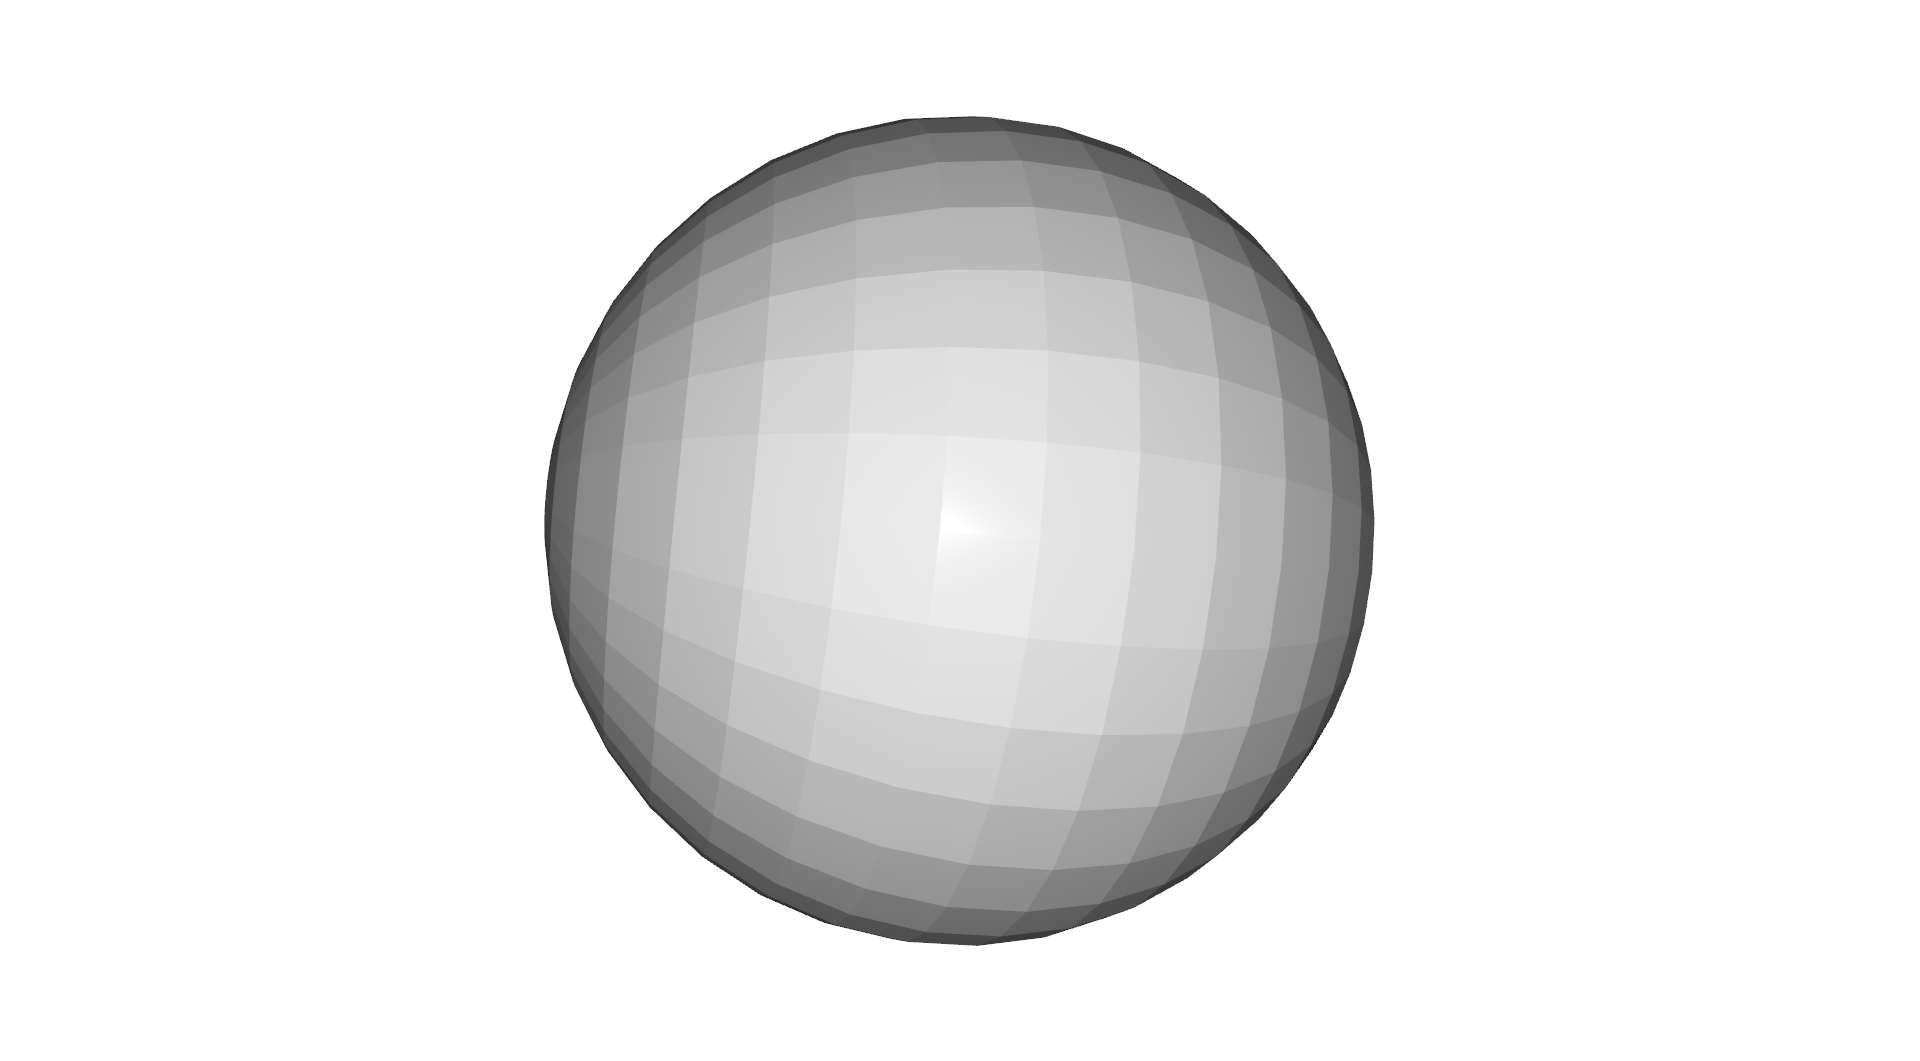

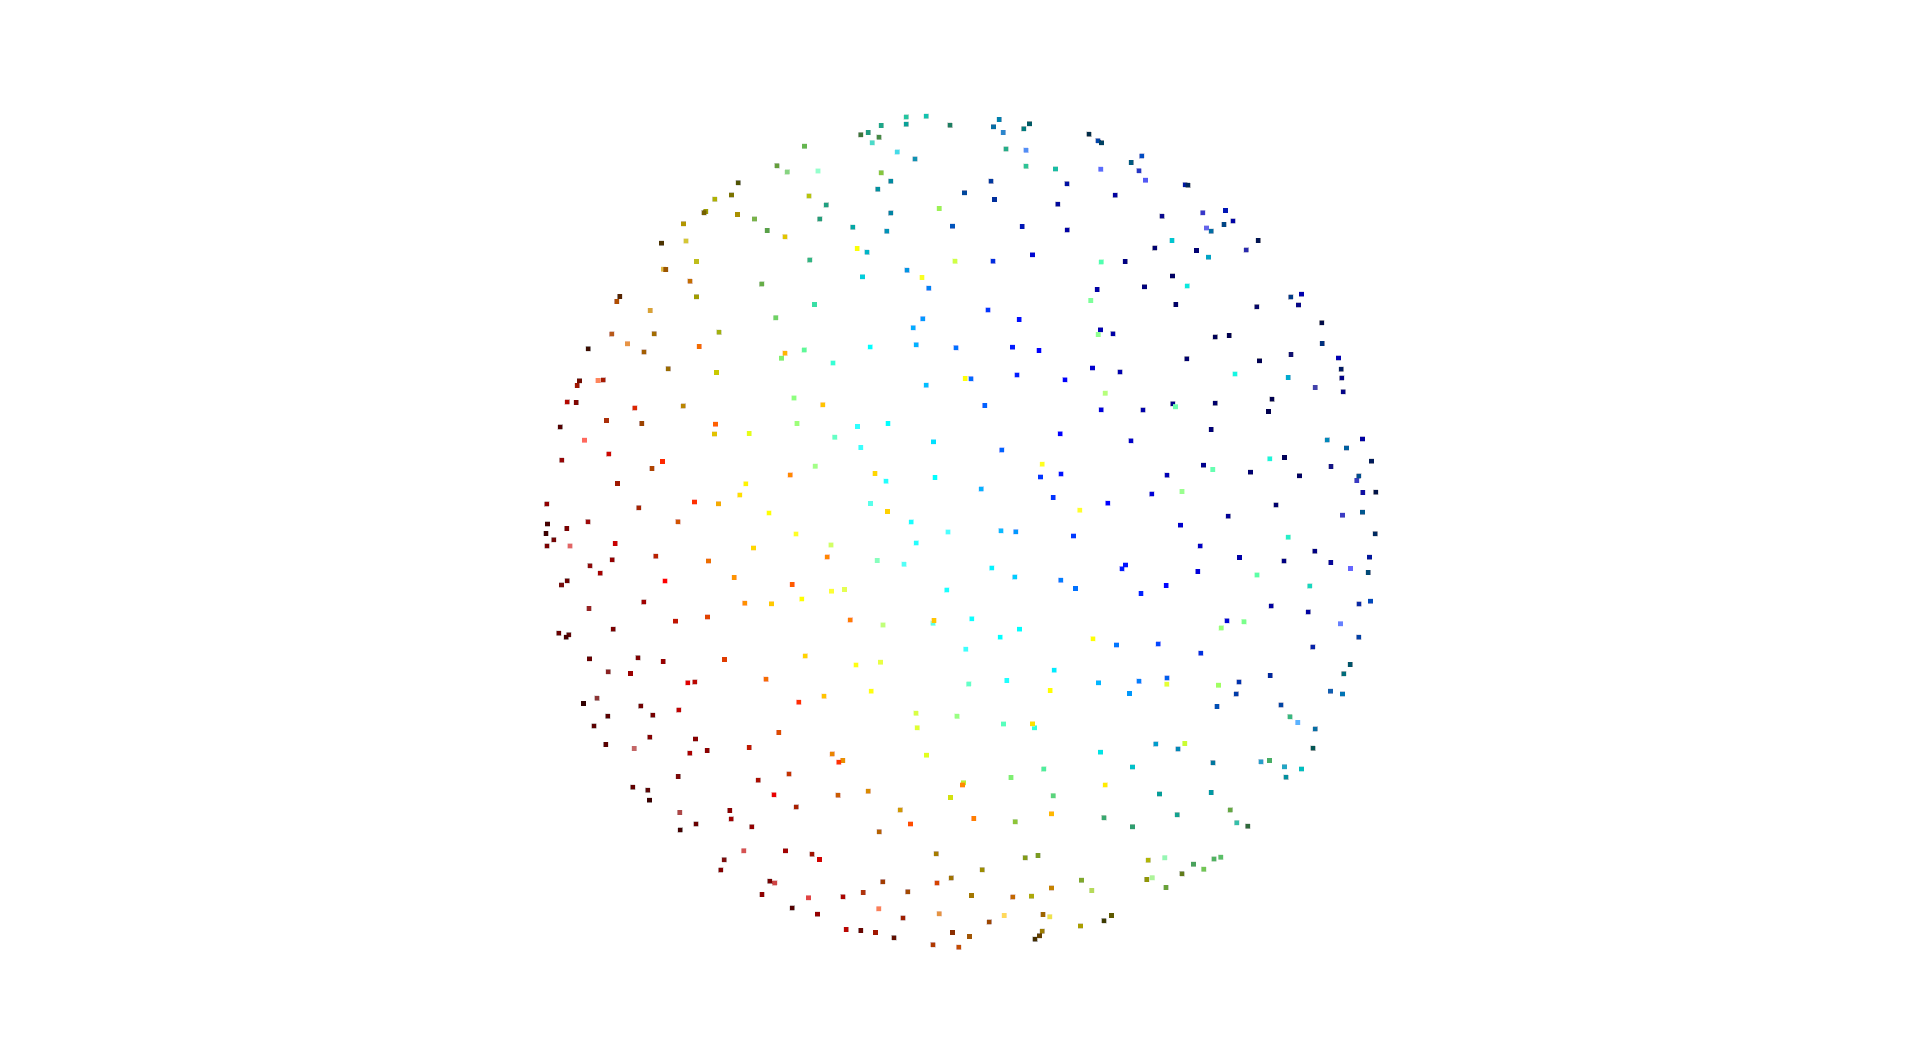

In [14]:
mesh = o3d.geometry.TriangleMesh.create_sphere()
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh])
pcd = mesh.sample_points_uniformly(number_of_points=500)
o3d.visualization.draw_geometries([pcd])

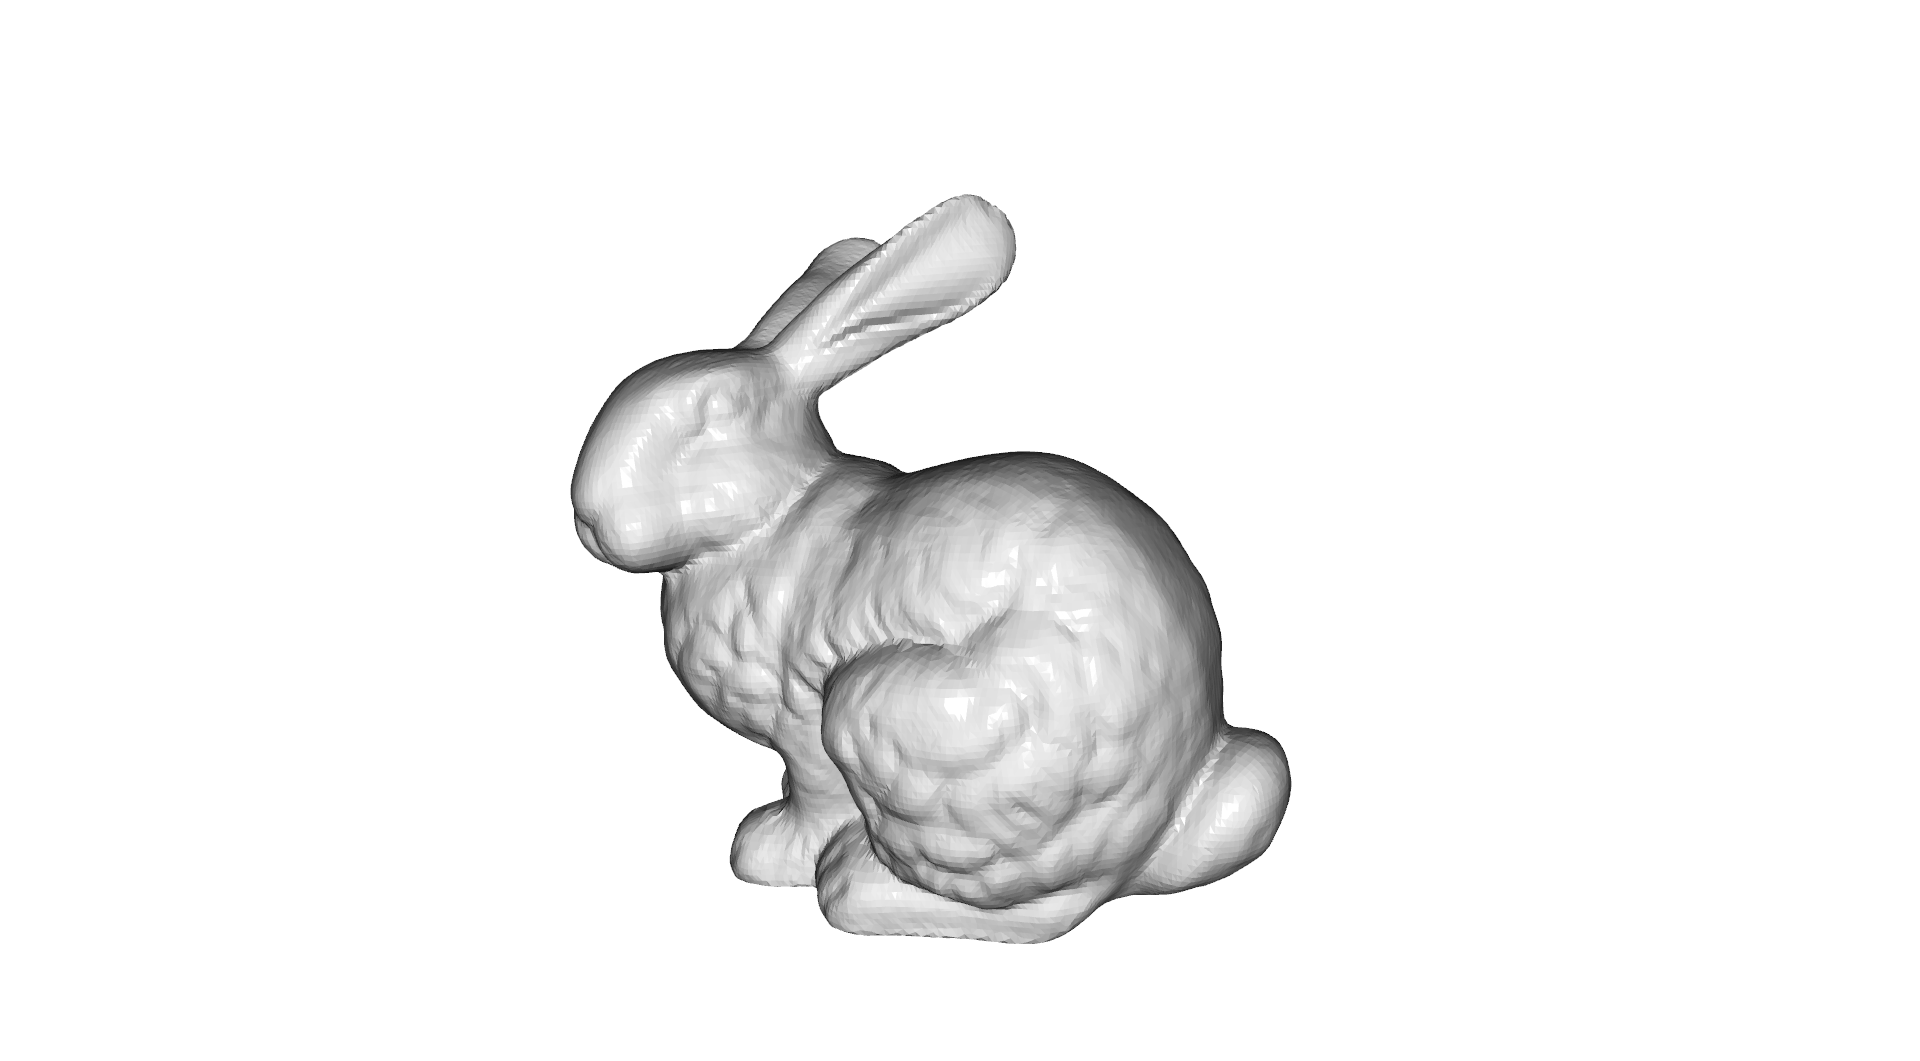

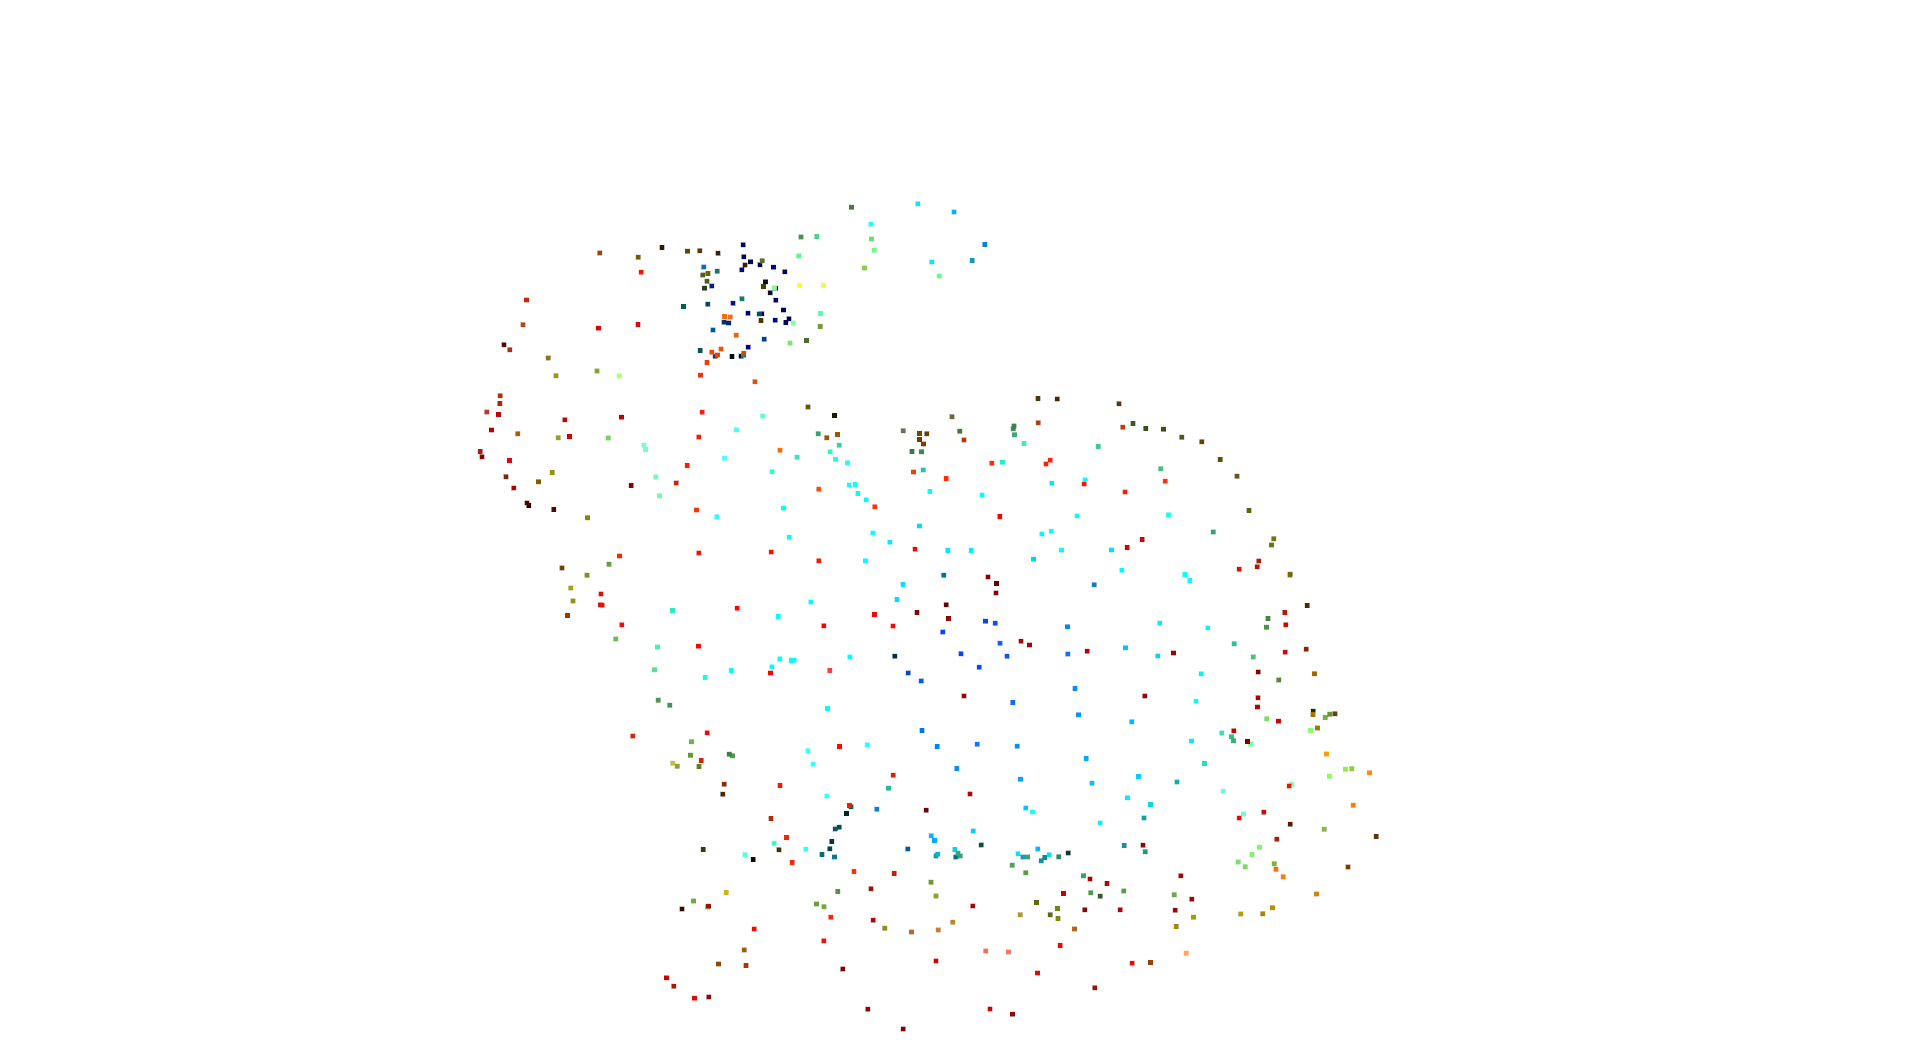

In [15]:
mesh = o3dtut.get_bunny_mesh()
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh])
pcd = mesh.sample_points_uniformly(number_of_points=500)
o3d.visualization.draw_geometries([pcd])

Uniform sampling can yield clusters of points on the surface, while a method called Poisson disk sampling can evenly distribute the points on the surface. The method `sample_points_poisson_disk` implements sample elimination. It starts with a sampled point cloud and removes points to satisfy the sampling criterion. The method supports two options to provide the initial point cloud:

1. Default via the parameter `init_factor`: The method first samples uniformly a point cloud from the mesh with `init_factor` x `number_of_points` and uses this for the elimination.
2. One can provide a point cloud and pass it to the `sample_points_poisson_disk` method. Then, this point cloud is used for elimination.

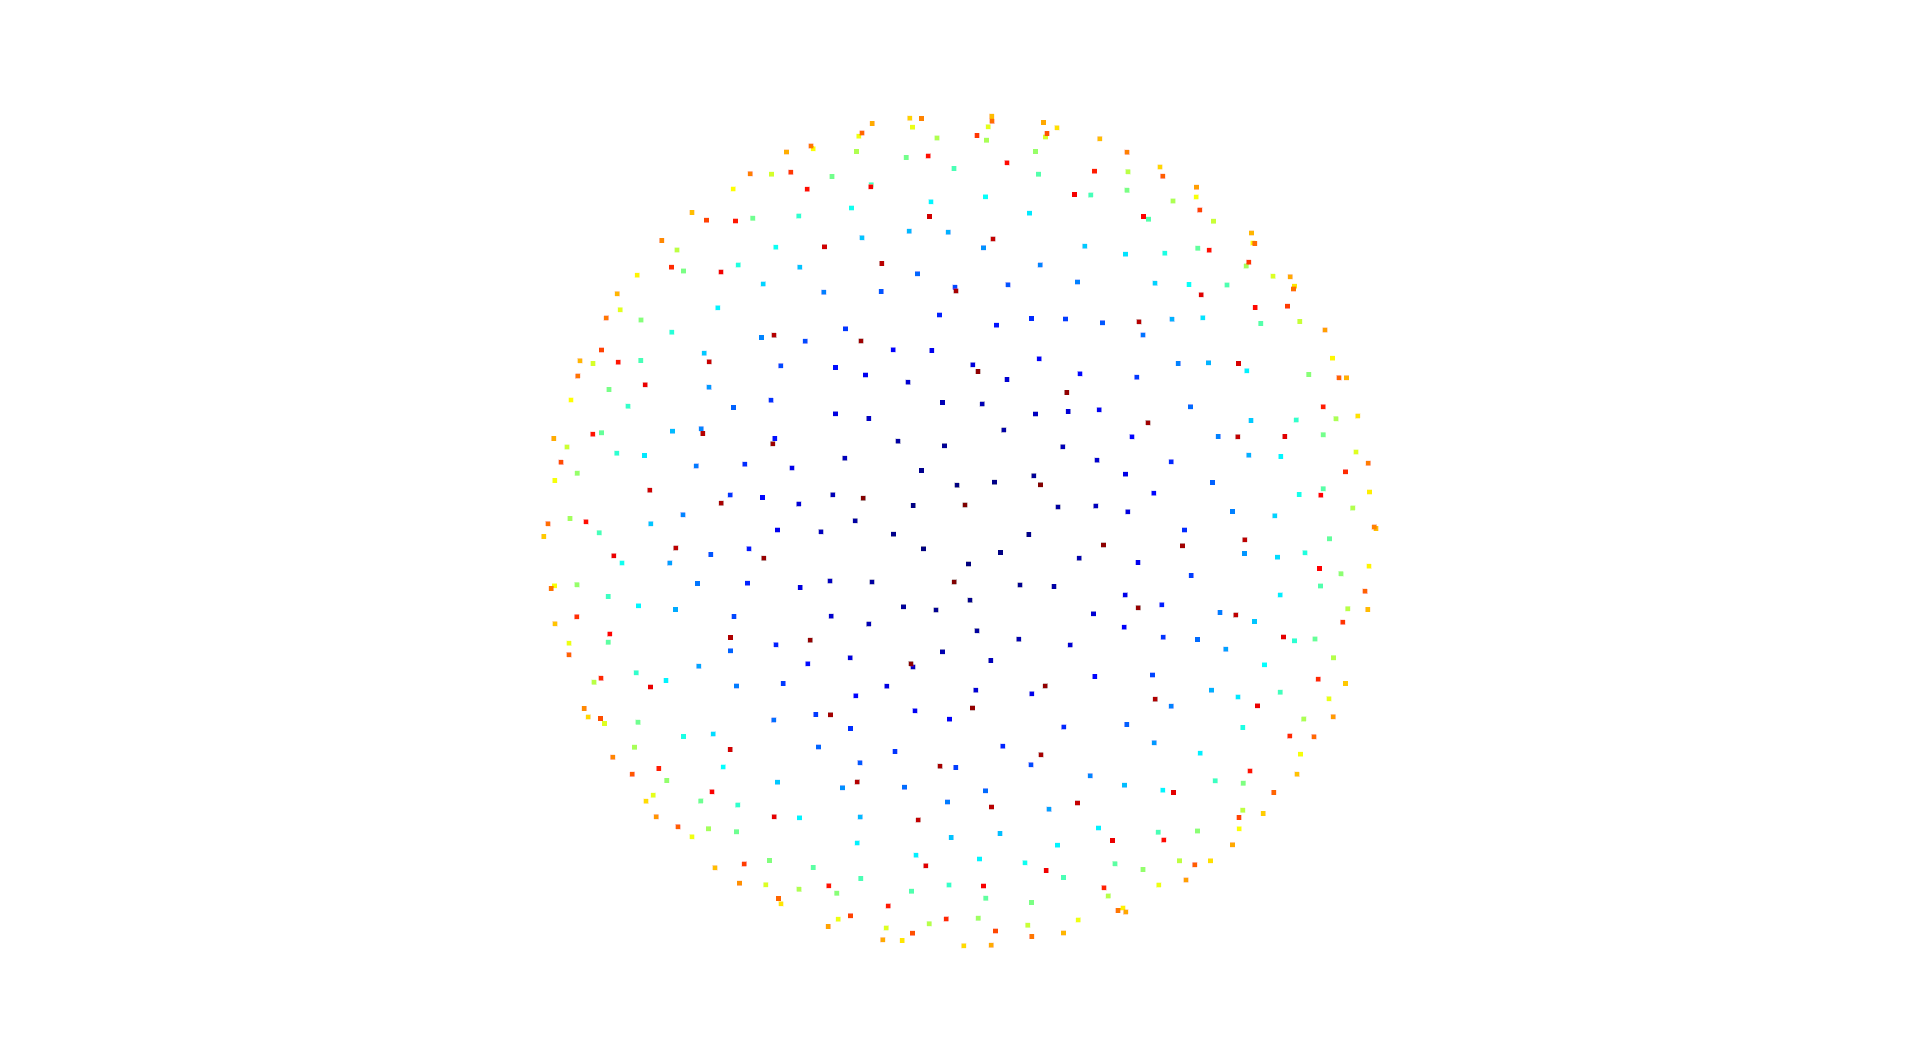

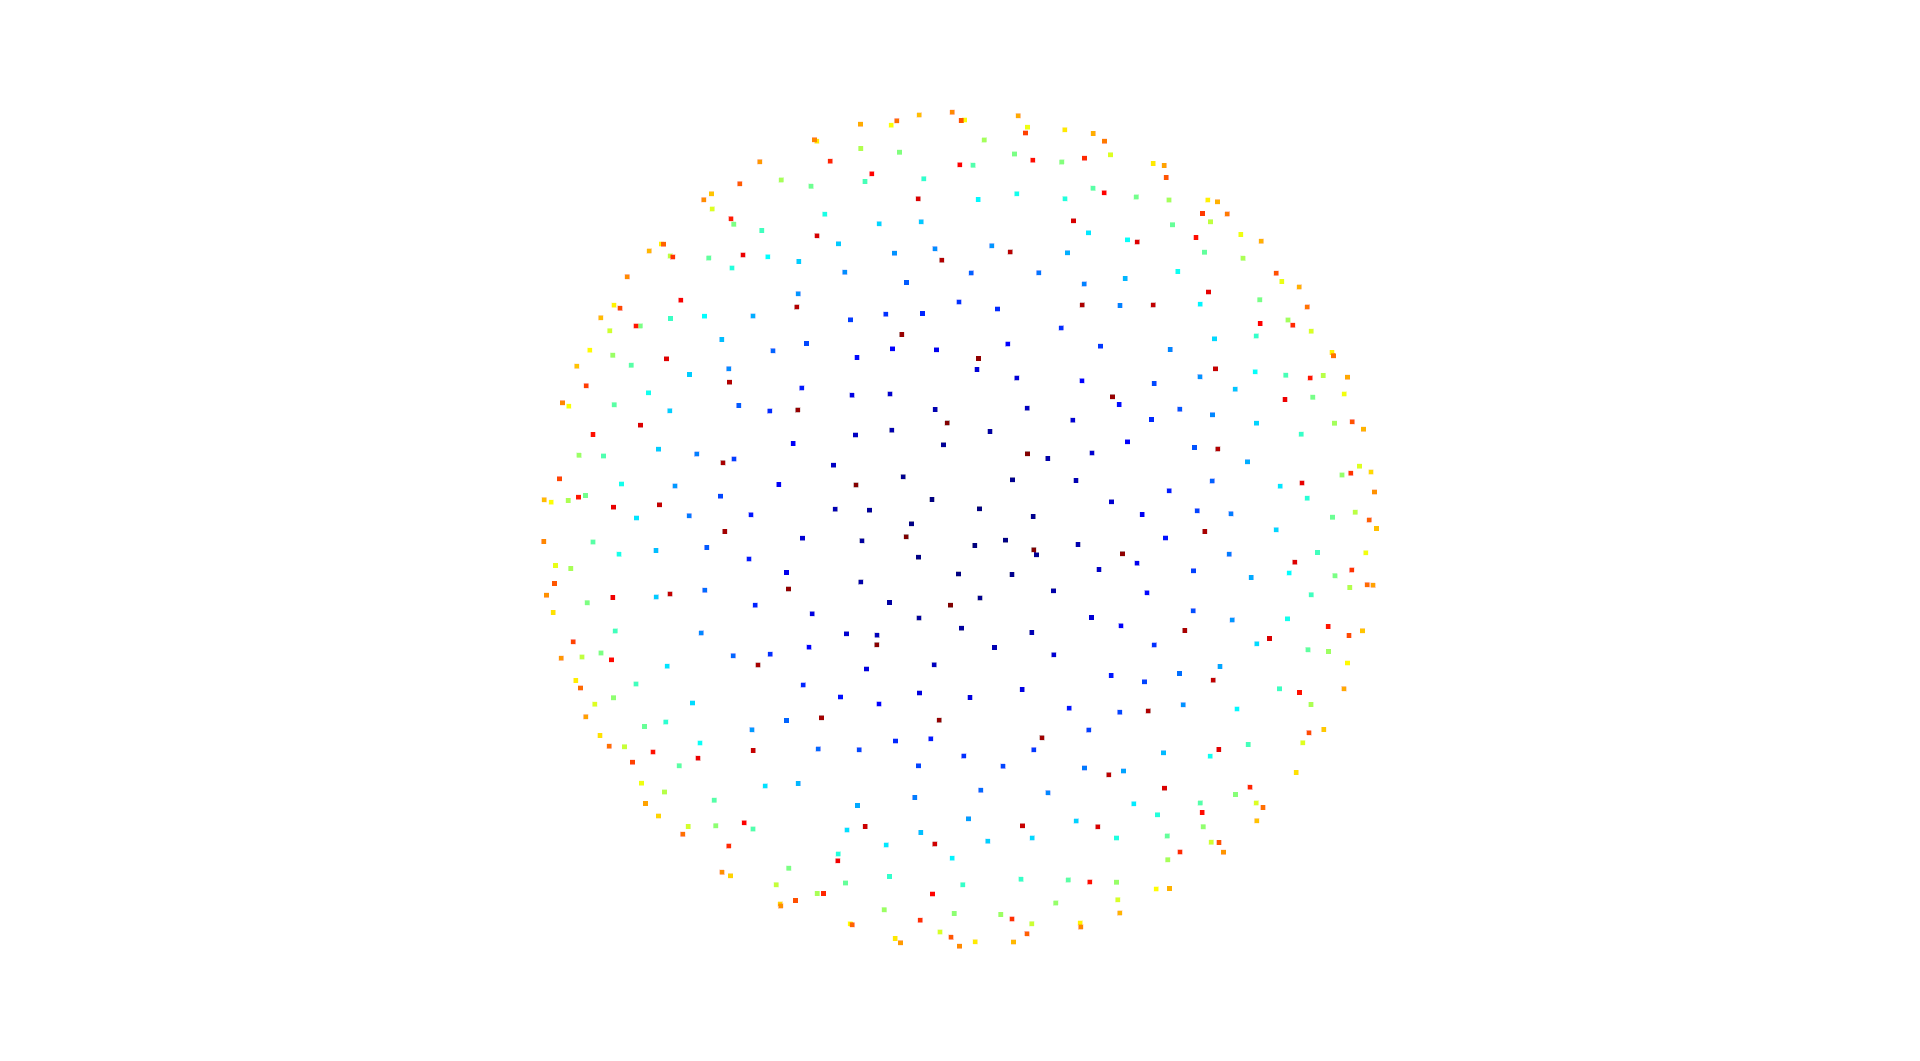

In [16]:
mesh = o3d.geometry.TriangleMesh.create_sphere()
pcd = mesh.sample_points_poisson_disk(number_of_points=500, init_factor=5)
o3d.visualization.draw_geometries([pcd])

pcd = mesh.sample_points_uniformly(number_of_points=2500)
pcd = mesh.sample_points_poisson_disk(number_of_points=500, pcl=pcd)
o3d.visualization.draw_geometries([pcd])

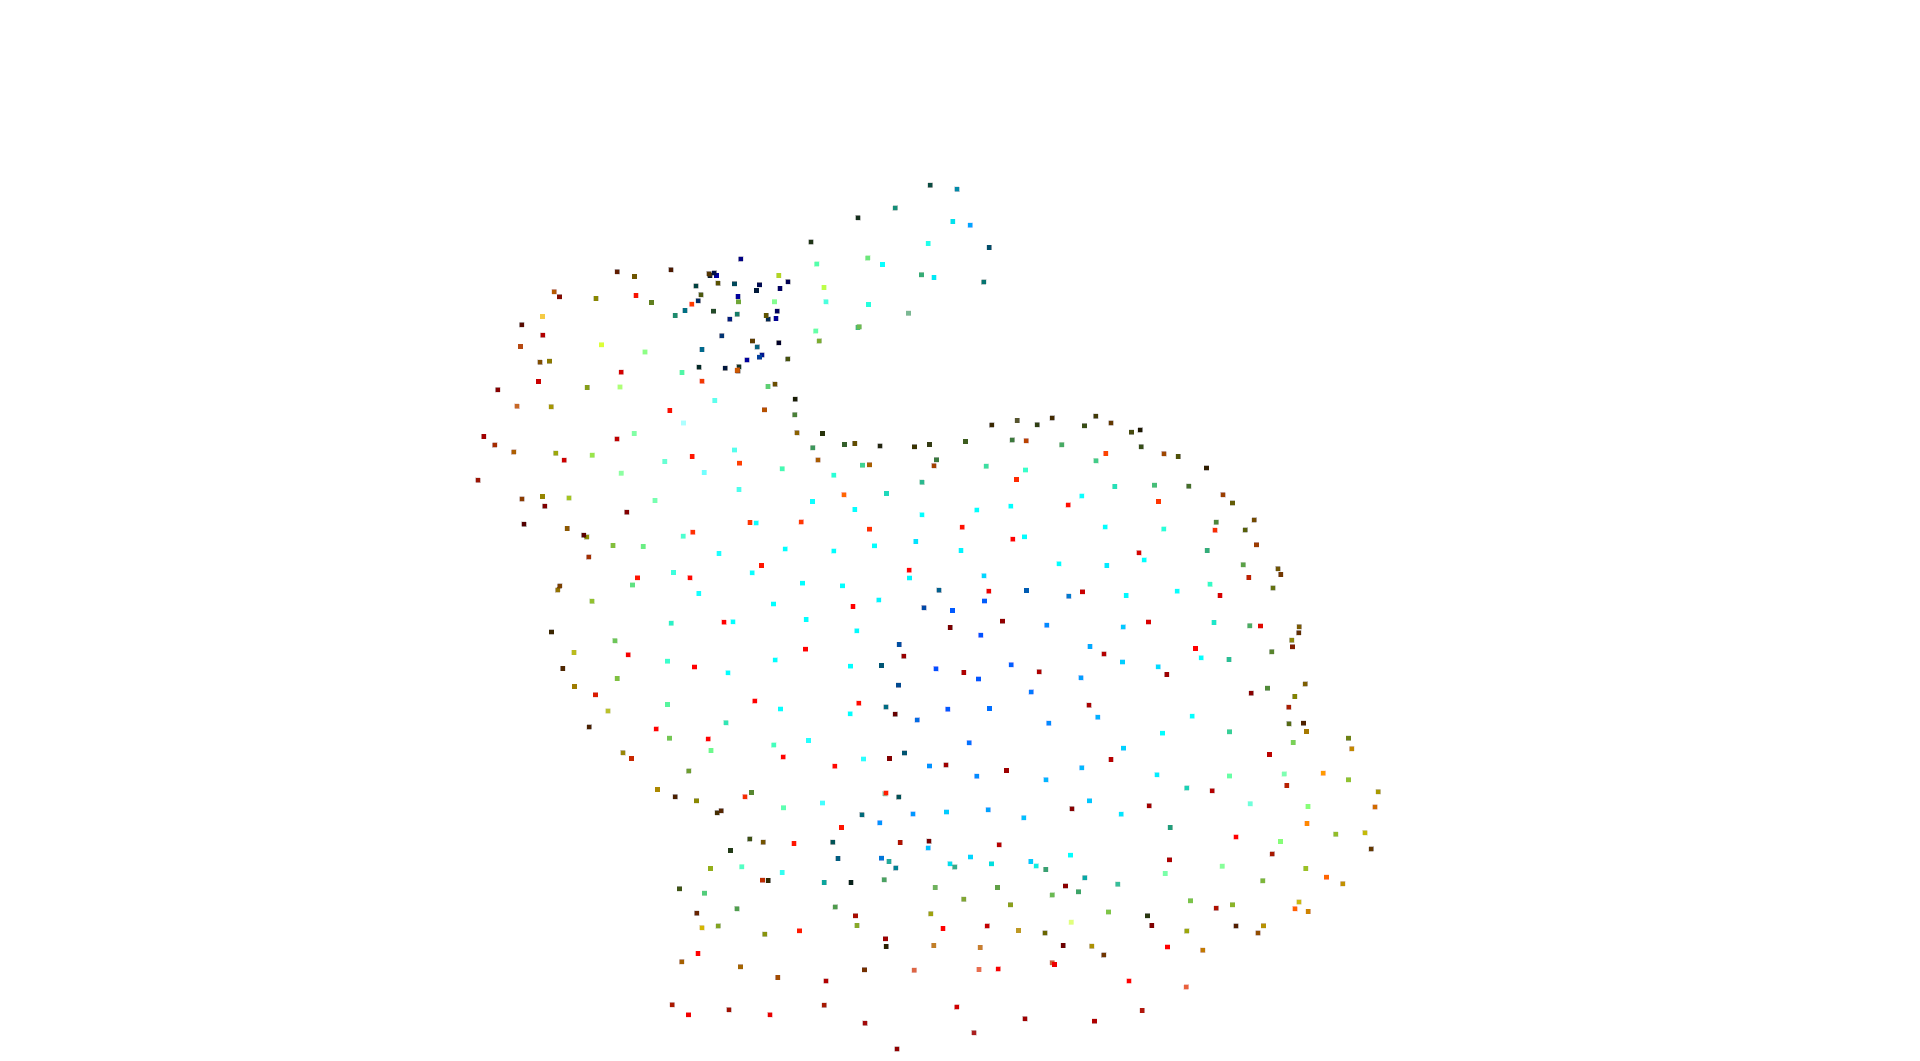

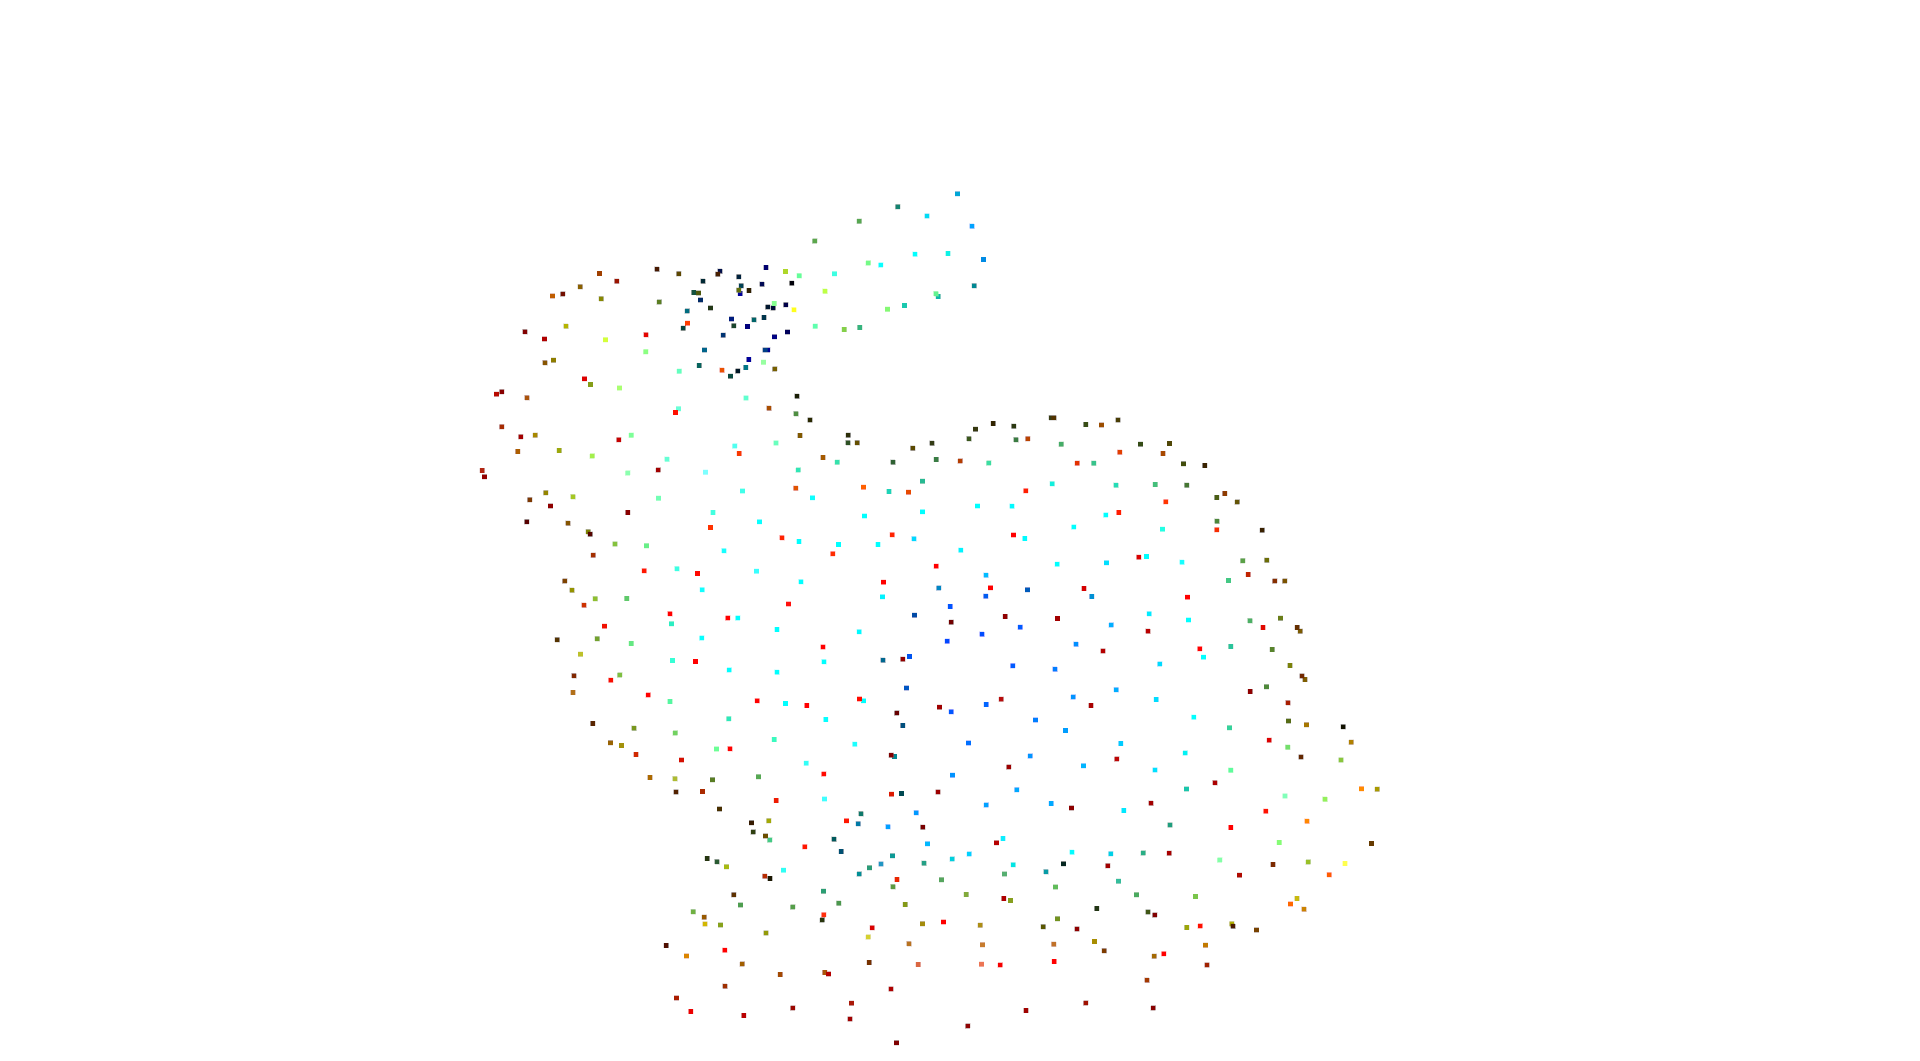

In [17]:
mesh = o3dtut.get_bunny_mesh()
pcd = mesh.sample_points_poisson_disk(number_of_points=500, init_factor=5)
o3d.visualization.draw_geometries([pcd])

pcd = mesh.sample_points_uniformly(number_of_points=2500)
pcd = mesh.sample_points_poisson_disk(number_of_points=500, pcl=pcd)
o3d.visualization.draw_geometries([pcd])

## Mesh subdivision
In mesh subdivision we divide each triangle into a number of smaller triangles. In the simplest case, we compute the midpoint of each side per triangle and divide the triangle into four smaller triangles. This is implemented in the `subdivide_midpoint` function. The 3D surface and area stays the same, but the number of vertices and triangles increases. The parameter `number_of_iterations` defines how many times this process should be repeated.

In [ ]:
mesh = o3d.geometry.TriangleMesh.create_box()
mesh.compute_vertex_normals()
print(
    f'The mesh has {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh], zoom=0.8, mesh_show_wireframe=True)
mesh = mesh.subdivide_midpoint(number_of_iterations=1)
print(
    f'After subdivision it has {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh], zoom=0.8, mesh_show_wireframe=True)

Open3D implements an additional subdivision method based on [\[Loop1987\]](../reference.html#Loop1987). The method is based on a quartic box spline, which generates $C^2$ continuous limit surfaces everywhere except at extraordinary vertices where they are $C^1$ continuous. This leads to smoother corners.

In [ ]:
mesh = o3d.geometry.TriangleMesh.create_sphere()
mesh.compute_vertex_normals()
print(
    f'The mesh has {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh], zoom=0.8, mesh_show_wireframe=True)
mesh = mesh.subdivide_loop(number_of_iterations=2)
print(
    f'After subdivision it has {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh], zoom=0.8, mesh_show_wireframe=True)

In [ ]:
mesh = o3dtut.get_knot_mesh()
mesh.compute_vertex_normals()
print(
    f'The mesh has {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh], zoom=0.8, mesh_show_wireframe=True)
mesh = mesh.subdivide_loop(number_of_iterations=1)
print(
    f'After subdivision it has {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh], zoom=0.8, mesh_show_wireframe=True)

## Mesh simplification
Sometimes we want to represent a high-resolution mesh with fewer triangles and vertices, but the low-resolution mesh should still be close to the high-resolution mesh. For this purpose Open3D implements a number of mesh simplification methods.

### Vertex clustering
The vertex clustering method pools all vertices that fall into a voxel of a given size to a single vertex. The method is implemented in `simplify_vertex_clustering` and has as parameters `voxel_size` that defines the size of the voxel grid and `contraction` that defines how the vertices are pooled. `o3d.geometry.SimplificationContraction.Average` computes a simple average.

In [ ]:
mesh_in = o3dtut.get_bunny_mesh()
print(
    f'Input mesh has {len(mesh_in.vertices)} vertices and {len(mesh_in.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh_in])

voxel_size = max(mesh_in.get_max_bound() - mesh_in.get_min_bound()) / 32
print(f'voxel_size = {voxel_size:e}')
mesh_smp = mesh_in.simplify_vertex_clustering(
    voxel_size=voxel_size,
    contraction=o3d.geometry.SimplificationContraction.Average)
print(
    f'Simplified mesh has {len(mesh_smp.vertices)} vertices and {len(mesh_smp.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh_smp])

voxel_size = max(mesh_in.get_max_bound() - mesh_in.get_min_bound()) / 16
print(f'voxel_size = {voxel_size:e}')
mesh_smp = mesh_in.simplify_vertex_clustering(
    voxel_size=voxel_size,
    contraction=o3d.geometry.SimplificationContraction.Average)
print(
    f'Simplified mesh has {len(mesh_smp.vertices)} vertices and {len(mesh_smp.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh_smp])

### Mesh decimation
Another category of mesh simplification methods is mesh decimation that operates in incremental steps. We select a single triangle that minimizes an error metric and removes it. This is repeated until a required number of triangles is achieved. Open3D implements `simplify_quadric_decimation` that minimizes error quadrics (distances to neighboring planes). The parameter `target_number_of_triangles` defines the stopping critera of the decimation algorithm.

In [ ]:
mesh_smp = mesh_in.simplify_quadric_decimation(target_number_of_triangles=6500)
print(
    f'Simplified mesh has {len(mesh_smp.vertices)} vertices and {len(mesh_smp.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh_smp])

mesh_smp = mesh_in.simplify_quadric_decimation(target_number_of_triangles=1700)
print(
    f'Simplified mesh has {len(mesh_smp.vertices)} vertices and {len(mesh_smp.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh_smp])

## Connected components
The result of various reconstruction methods. Open3D implements a connected components algorithm `cluster_connected_triangles` that assigns each triangle to a cluster of connected triangles. It returns for each triangle the index of the cluster in `triangle_clusters`, and per cluster the number of triangles in `cluster_n_triangles` and the surface area of the cluster in `cluster_area`.

This is useful in for instance [RGBD Integration](../pipelines/rgbd_integration.ipynb), which is not always a single triangle mesh, but a number of meshes. Some of the smaller parts are due to noise and we most likely want to remove them.

The code below shows the application of `cluster_connected_triangles` and how it can be used to remove spurious triangles.

In [ ]:
print("Generate data")
mesh = o3dtut.get_bunny_mesh().subdivide_midpoint(number_of_iterations=2)
vert = np.asarray(mesh.vertices)
min_vert, max_vert = vert.min(axis=0), vert.max(axis=0)
for _ in range(30):
    cube = o3d.geometry.TriangleMesh.create_box()
    cube.scale(0.005, center=cube.get_center())
    cube.translate(
        (
            np.random.uniform(min_vert[0], max_vert[0]),
            np.random.uniform(min_vert[1], max_vert[1]),
            np.random.uniform(min_vert[2], max_vert[2]),
        ),
        relative=False,
    )
    mesh += cube
mesh.compute_vertex_normals()
print("Show input mesh")
o3d.visualization.draw_geometries([mesh])

In [ ]:
print("Cluster connected triangles")
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    triangle_clusters, cluster_n_triangles, cluster_area = (
        mesh.cluster_connected_triangles())
triangle_clusters = np.asarray(triangle_clusters)
cluster_n_triangles = np.asarray(cluster_n_triangles)
cluster_area = np.asarray(cluster_area)

In [ ]:
print("Show mesh with small clusters removed")
mesh_0 = copy.deepcopy(mesh)
triangles_to_remove = cluster_n_triangles[triangle_clusters] < 100
mesh_0.remove_triangles_by_mask(triangles_to_remove)
o3d.visualization.draw_geometries([mesh_0])

In [ ]:
print("Show largest cluster")
mesh_1 = copy.deepcopy(mesh)
largest_cluster_idx = cluster_n_triangles.argmax()
triangles_to_remove = triangle_clusters != largest_cluster_idx
mesh_1.remove_triangles_by_mask(triangles_to_remove)
o3d.visualization.draw_geometries([mesh_1])